## Credit Card Fraud Detection

In this project you will predict fraudulent credit card transactions with the help of Machine learning models. Please import the following libraries to get started.

 ## Table of Contents
  - [Inroduction](#intro)
  - [Helper Function](#helper)
  - [Exploratory data analytics (EDA)](#eda)
  - [Model building / hyperparameter tuning / Model Evaluation ](#build)
  - [Conclusion](#end)

<a id='intro'></a>

# Introduction

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing

<a id='helper'></a>

# Helper Functions

In [2]:
# plot the histogram of a variable from the dataset to see the skewnes
def plot_skewness_histogram(df):
    k = 0
    plt.figure(figsize=(12, 20))
    for col in df.columns:
      k=k+1
      plt.subplot(6, 5, k)
      sns.histplot(df[col])
      plt.tight_layout()
      plt.title(col + ' (Skewness =' + str(round(df[col].skew(), 3)) +')')

In [3]:
# Helper Function to test the classification model 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
import json


def test_classification_model(model, X, y, test_size=0.2, random_state=42, hyperparameters=None):
    """
    Test a classification model and return evaluation metrics.

    Parameters:
    - model: The classification model to test (e.g., RandomForestClassifier, LogisticRegression, etc.).
    - X: The feature matrix.
    - y: The target vector.
    - test_size: The proportion of the dataset to include in the test split (default is 0.2).
    - random_state: Seed for random number generator for reproducibility (default is 42).
    - hyperparameters: Dictionary of hyperparameters for model tuning (default is None).

    Returns:
    - Dictionary containing the evaluation metrics: accuracy, precision, recall, F1 score, and confusion matrix.
    """
    print("Processing for the Model : {} ".format(model))
    # Split the dataset into training and testing sets
    print("Splitting train and test for the Model : {} ".format(model))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    # Creating KFold object with 5 splits
    print("Creating KFold object with 5 splits")
    folds = KFold(n_splits=5, random_state=4, shuffle=True)
    print("Configuring hyper parameter  for the Model : {}  with hyperparamer {}".format(model,hyperparameters))
    if hyperparameters is not None:
        # Perform hyperparameter tuning using GridSearchCV
        grid_search = GridSearchCV(model, param_grid = hyperparameters, cv=folds,verbose=2, scoring ='roc_auc',return_train_score=True)
        grid_search.fit(X_train, y_train)
        model_cv = grid_search.best_estimator_
    print("Fitting the Model : {} ".format(model))
    # Fit the model to the training data
    model_cv.fit(X_train, y_train)

    print("Predicting  the Model : {} ".format(model))
    # Make predictions on the test data
    y_pred = model_cv.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    sensitivity = TP / float(TP+FN)
    specificity = TN / float(TN+FP)
    
    # Calculate ROC curve and ROC AUC score
    y_prob = model_cv.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    



    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Store the metrics in a dictionary
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': confusion,
        'ROC AUC': roc_auc,
        'sensitivity':sensitivity,
        'specificity' : specificity,
        'Best_Model' : model_cv
    }
    # results of GridSearchCV
    cv_results = pd.DataFrame(grid_search.cv_results_)
    print("The CV results for the model {} ".format(model))
    display(cv_results)
    

    print("The Metrics for the best score {}  and Best Estimator {} ".format(grid_search.best_score_,grid_search.best_estimator_))
    return metrics

In [4]:
# ROC Curve function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [5]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

def perform_resampling(X, y, method='random'):
    """
    Resample the imbalanced dataset using RandomOverSampler, SMOTE, or ADASYN.

    Parameters:
        X (array-like): The feature matrix.
        y (array-like): The target vector.
        method (str): The resampling method to use ('random', 'smote', or 'adasyn').

    Returns:
        X_resampled (array-like): The resampled feature matrix.
        y_resampled (array-like): The resampled target vector.
    """
    if method == 'random':
        sampler = RandomOverSampler(random_state=42)
    elif method == 'smote':
        sampler = SMOTE(random_state=42)
    elif method == 'adasyn':
        sampler = ADASYN(random_state=42)
    else:
        raise ValueError("Invalid resampling method. Use 'random', 'smote', or 'adasyn'.")

    X_resampled, y_resampled = sampler.fit_resample(X, y)
    return X_resampled, y_resampled

In [6]:
# Create an empty DataFrame to store the metrics
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score' , 'Best_Model','Confusion Matrix','ROC AUC', 'Threshold' ,'ROC AUC - Test Data'])

def create_classification_report(models,metrics_df,X_train, y_train):
    # Test each model and store the metrics in the DataFrame
    for model_name, (model, hyperparameters) in models.items():
        metrics_info = test_classification_model(model,X_train, y_train,hyperparameters=hyperparameters)
        metrics_df = metrics_df.append({'Model': model_name, **metrics_info}, ignore_index=True)
        #display(metrics_df)
    # Display the metrics DataFrame
    print("Final Metrics and the Model information")
    print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX\n\n")
    display(metrics_df.sort_values(by=['ROC AUC'],ascending=False).reset_index(drop=True))
    return metrics_df

In [7]:
def create_model_threshold(models,metrics_df):
    import warnings

    # Disable the warning
    warnings.filterwarnings('ignore', message="X does not have valid feature names")
    # Predictions on the test set using Logistic regression  and XgBost
    from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report,roc_curve
    #metrics_df['Threshold'] = "NA"
    #metrics_df['ROC AUC - Test Data'] = "NA"
    from sklearn import metrics
    for key in models.keys():
        #print(key)
        best_model = metrics_df[metrics_df['Model'] == key]['Best_Model'].values[0]
        #print(best_model)
        pred_proba = best_model.predict_proba(X_test)[:,1]
        auc = metrics.roc_auc_score(y_test, pred_proba)
        print("AUC score for the Model {} : {}".format(key,auc))
        #print('Train auc  =', metrics.roc_auc_score(y_test,pred_proba))
        fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba)

        threshold = thresholds[np.argmax(tpr-fpr)]
        print("Threshold for the model {}  = {} ".format(key,threshold))
        print("================================ ")
        metrics_df.loc[metrics_df['Model'] == key , 'Threshold'] = threshold
        metrics_df.loc[metrics_df['Model'] == key , 'ROC AUC - Test Data'] = auc
        #display(metrics_df.sort_values(by=['ROC AUC'],ascending=False).reset_index(drop=True))
        print("RoC curve for model {} ".format(key))
        print("================================ ")
        draw_roc(y_test, pred_proba)
        #print("Clasification Report for {}".format(key))
        #print("================================ ")
        #print(classification_report(y_test, pred_proba))
    return metrics_df

<a id='eda'></a>

## Exploratory data analysis

First look at the data used here from the Kaggle dataset suggests that it is highly imbalanced
in nature.

The positive class (frauds) account for only 0.172% of all transactions: i.e 284315 non-fradulent and 492 Fradulent


Class is the target variable which we have to predict where 0 is non-fradulent and 1 is
fraudulent transaction.


Features V1, V2, … V28 are the principal components obtained with PCA, the only features
which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains
the seconds elapsed between each transaction and the first transaction in the dataset. The
feature 'Amount' is the transaction Amount, this feature can be used for exampledependant cost-senstive learning.


We can start with the basic EDA like correlation, boxplots etc for outliers.
Next, we can use transformation to mitigate and check the skewness in the data. (Boxcox,
Log transformation, Yeo-Johnson etc)

The normal Oversampling method won’t be used here as it does not add any new information to
the dataset and Undersampling will also not be used as it leads to the loss of information.
Next, we will try the below two class imbalance handling techniques:


• SMOTE is a process where you can generate new data points, which lie vectorially between
two data points that belong to the minority class.


• ADASYN is similar to SMOTE, with a minor change i.e. the number of synthetic samples that
it will add will have a density distribution. The aim here is to create synthetic data for
minority examples that are harder to learn, rather than the easier ones.

We also showed the RandomOversampling/SMOTE and ADASYN to balance the class imbalance and try to make model and evaluated the results 

In [8]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
#observe the different feature type present in the data

df.shape

(284807, 31)

In [10]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [11]:
#Check the Means and Standard deviation to undetstand if we need to scale it 
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [12]:
# Check for any null Values . NO NULL VALUES !!!!
df.isnull().sum().sum()

0

In [13]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [14]:
# You can see 99% is with Class0 and less than 1% is with class1 . so it is highly imba,lanced 
df['Class'].value_counts(normalize = True)*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

Here we will observe the distribution of our classes

In [15]:
classes=df['Class'].value_counts()

normal_count = classes[0]
fraud_count = classes[1]
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

In [16]:
plot_data = pd.DataFrame({'Count': [normal_count, fraud_count], 'Percentage': [normal_share, fraud_share]}, index=['Non-Fraudulent', 'Fraudulent'])
plot_data


,Count,Percentage
Non-Fraudulent,284315,99.827251
Fraudulent,492,0.172749


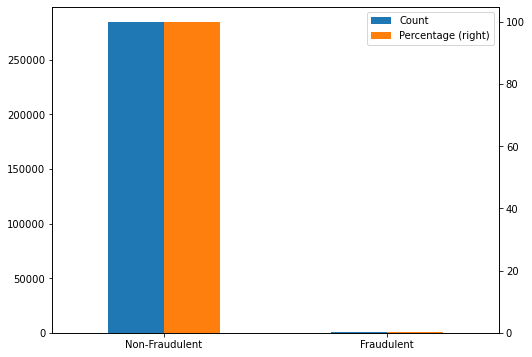

In [17]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
plot_data.plot(kind='bar', secondary_y='Percentage', rot=0, figsize=(8, 6))
plt.show()

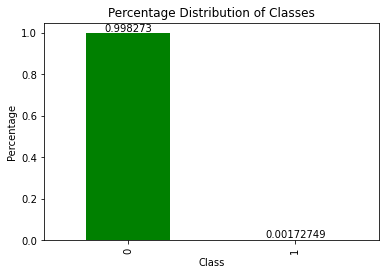

In [18]:
ax = df['Class'].value_counts(normalize = True).plot.bar(color = ['g', 'r'])
ax.bar_label(ax.containers[0], label_type='edge')
plt.title('Percentage Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.show()

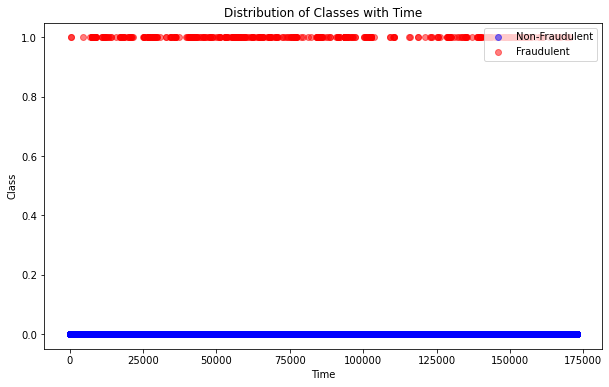

In [19]:
# Create a scatter plot to observe the distribution of classes with time

import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Time'][df['Class'] == 0], df['Class'][df['Class'] == 0], label='Non-Fraudulent', alpha=0.5, c='b')
plt.scatter(df['Time'][df['Class'] == 1], df['Class'][df['Class'] == 1], label='Fraudulent', alpha=0.5, c='r')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Class')
plt.title('Distribution of Classes with Time')
plt.legend(loc='upper right')
plt.show()

# We don;t see any Fradulant with the Time Coloum so probably we can drop this 

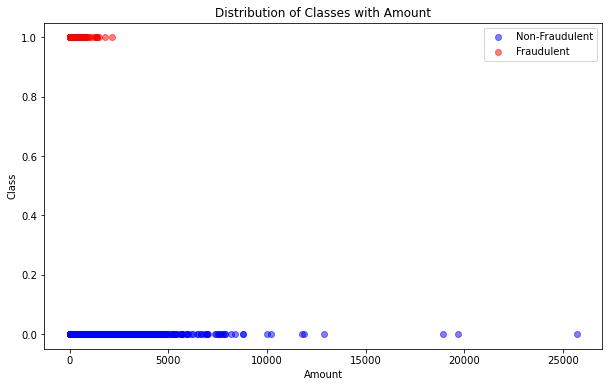

In [20]:
# Create a scatter plot to observe the distribution of classes with Amount
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Amount'][df['Class'] == 0], df['Class'][df['Class'] == 0], label='Non-Fraudulent', alpha=0.5, c='b')
plt.scatter(df['Amount'][df['Class'] == 1], df['Class'][df['Class'] == 1], label='Fraudulent', alpha=0.5, c='r')

# Customize the plot
plt.xlabel('Amount')
plt.ylabel('Class')
plt.title('Distribution of Classes with Amount')
plt.legend(loc='upper right')
plt.show()



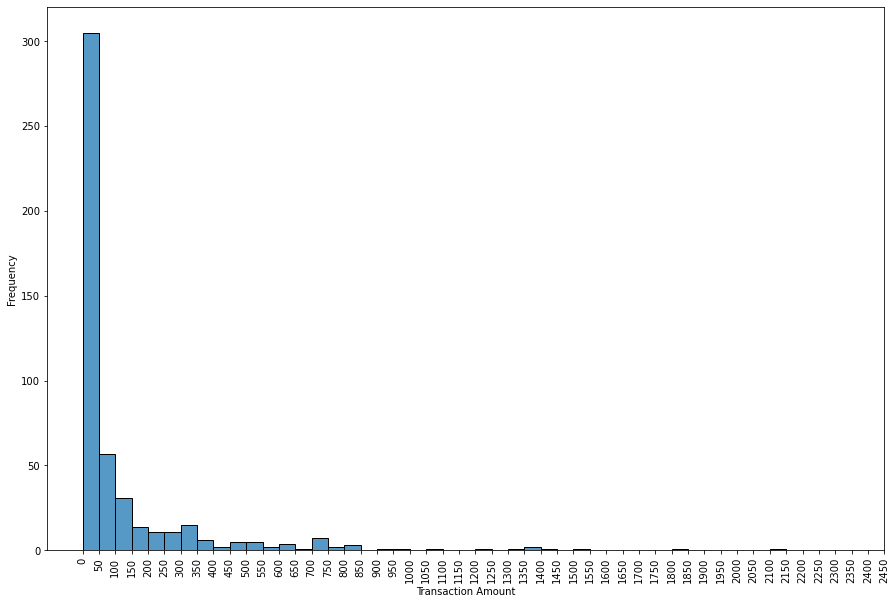

In [21]:
# creating fradulant dataframes
data_fraud = df[df['Class'] == 1]

# Creating non fraudulent dataframe
data_non_fraud = df[df['Class'] == 0]

# distribution of Fradulent data

plt.figure(figsize=(15, 10))
sns.histplot(data_fraud['Amount'], binwidth=50)
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.xticks(range(0, 2500, 50), rotation=90)
plt.show()

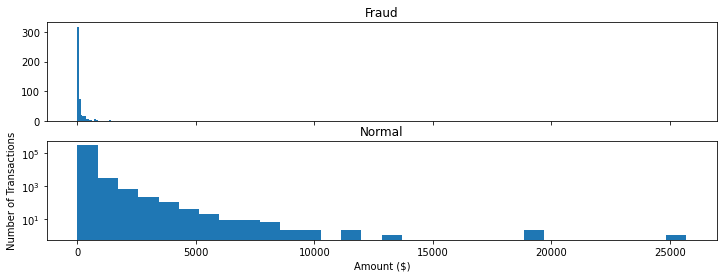

In [22]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30

ax1.hist(df.Amount[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Amount[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

## Correlation

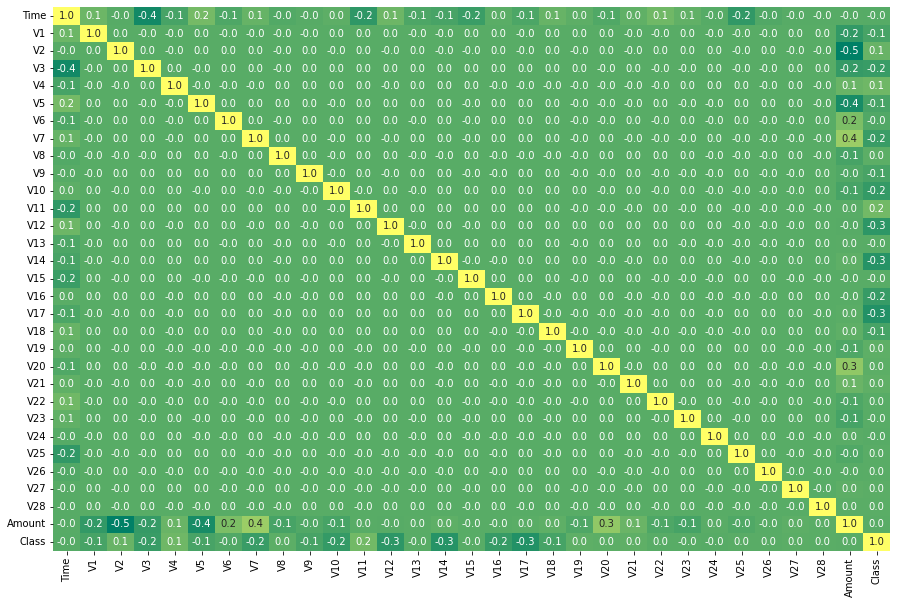

In [23]:

plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, cbar=False, fmt='.1f', cmap='summer')
plt.show()

## Outlier

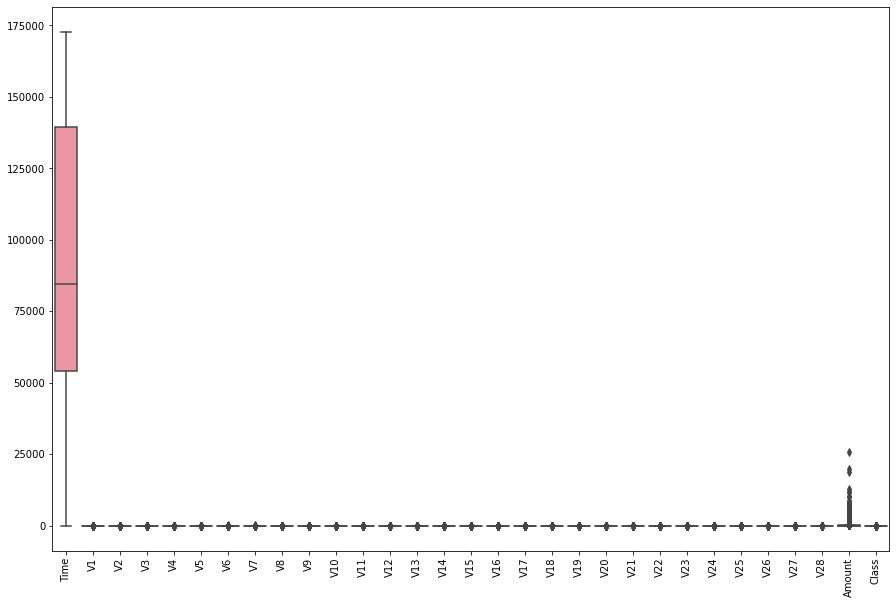

In [24]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

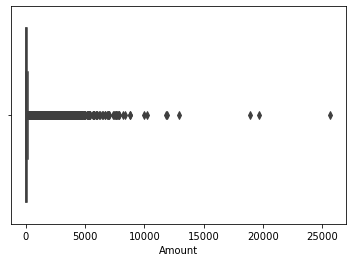

In [25]:
plt.tight_layout()
sns.boxplot(x=df['Amount'], data=df)
plt.show()

#####  Most of the fradulent transactions are in the range of 0-50 dollars

In [26]:
# Drop unnecessary columns. As mentioned above we don;t find much value in "Time" coloumn so dropping it 
data = df.drop('Time', axis=1)

In [27]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [28]:
data.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [29]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [30]:
display(data.shape)
display(df.shape)

(284807, 30)

(284807, 31)

### Splitting the data into train & test data

In [31]:
from sklearn.model_selection import train_test_split
# Lables on the y 
y= data['Class']
#  All features in X
X = data.drop(['Class'], axis=1)

In [32]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, stratify=y, random_state=42)

##### Preserve X_test & y_test to evaluate on the test data once you build the model

In [33]:
print(" Number of Record  of Total Class : {}".format(y.shape))
print(" Number of Record  of Total Dependent Variable : {}".format(X.shape))
print(" Number of Record  of Total X_train : {}".format(X_train.shape))
print(" Number of Record  of Total y_train : {}".format(y_train.shape))
print(" Number of Record  of Total X_test : {}".format(X_test.shape))
print(" Number of Record  of Total y_test : {}".format(y_test.shape))

 Number of Record  of Total Class : (284807,)
 Number of Record  of Total Dependent Variable : (284807, 29)
 Number of Record  of Total X_train : (199364, 29)
 Number of Record  of Total y_train : (199364,)
 Number of Record  of Total X_test : (85443, 29)
 Number of Record  of Total y_test : (85443,)


In [34]:
X_train.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,...,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000
mean,-0.001137,-0.002024,-0.001333,0.000313,0.000202,0.000302,-0.000307,-0.001291,0.001995,0.000398,...,-0.001012,0.000459,0.000360,0.000731,-0.000054,-0.000550,0.000072,-0.000405,0.000522,88.384784
std,1.965794,1.658079,1.519820,1.416731,1.387295,1.336558,1.248395,1.198699,1.098649,1.090521,...,0.776632,0.740233,0.726146,0.625116,0.605084,0.521473,0.482197,0.407727,0.329701,253.066081
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,...,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000
25%,-0.919472,-0.600466,-0.890875,-0.846902,-0.691963,-0.768846,-0.553719,-0.208460,-0.640513,-0.534928,...,-0.211792,-0.228438,-0.542054,-0.162021,-0.354888,-0.317041,-0.326836,-0.070712,-0.052910,5.670000
50%,0.017529,0.064591,0.180371,-0.020802,-0.054897,-0.273921,0.040482,0.022954,-0.050199,-0.093119,...,-0.062695,-0.029121,0.006539,-0.010594,0.041130,0.016344,-0.052065,0.001367,0.011266,22.000000
75%,1.315404,0.804932,1.026038,0.743833,0.611243,0.398847,0.571020,0.326971,0.600147,0.455546,...,0.133000,0.186562,0.528738,0.147946,0.439173,0.350126,0.240930,0.091088,0.078266,77.500000
max,2.451888,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,...,39.420904,27.202839,10.503090,22.083545,4.584549,6.070850,3.517346,31.612198,33.847808,25691.160000


In [35]:
pd.DataFrame(X_test).describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,...,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000
mean,0.002652,0.004723,0.003111,-0.000730,-0.000471,-0.000705,0.000717,0.003012,-0.004654,-0.000929,...,0.002361,-0.001070,-0.000841,-0.001706,0.000125,0.001284,-0.000167,0.000944,-0.001218,88.267570
std,1.942042,1.635401,1.507909,1.413863,1.363668,1.322221,1.210320,1.184152,1.098586,1.084946,...,0.757442,0.721031,0.724668,0.622929,0.606963,0.520825,0.482299,0.393915,0.330973,243.108931
min,-37.558067,-50.383269,-32.454198,-5.600607,-40.427726,-19.996349,-33.239328,-50.688419,-10.842526,-22.187089,...,-28.009635,-22.757540,-8.887017,-32.828995,-2.824849,-8.696627,-1.855355,-9.845808,-8.412267,0.000000
25%,-0.922038,-0.594262,-0.889098,-0.851954,-0.690363,-0.767103,-0.554594,-0.208937,-0.649210,-0.536137,...,-0.211571,-0.228236,-0.542817,-0.161437,-0.353614,-0.317478,-0.327388,-0.071227,-0.053131,5.500000
50%,0.019089,0.068355,0.178479,-0.017874,-0.052915,-0.274978,0.039406,0.020753,-0.053320,-0.092409,...,-0.061898,-0.030267,0.007763,-0.012450,0.040595,0.017118,-0.052227,0.001271,0.011194,21.990000
75%,1.316257,0.800600,1.029617,0.742116,0.614065,0.397743,0.568829,0.328104,0.590206,0.449771,...,0.133089,0.186072,0.528260,0.147063,0.440589,0.352148,0.241009,0.090957,0.078359,76.800000
max,2.454930,17.930550,4.226108,12.132323,28.762671,23.917837,44.054461,18.282168,9.272376,13.811758,...,26.237391,27.202839,8.272233,22.528412,4.022866,7.519589,3.119295,10.507884,22.620072,12910.930000


### Plotting the distribution of a variable

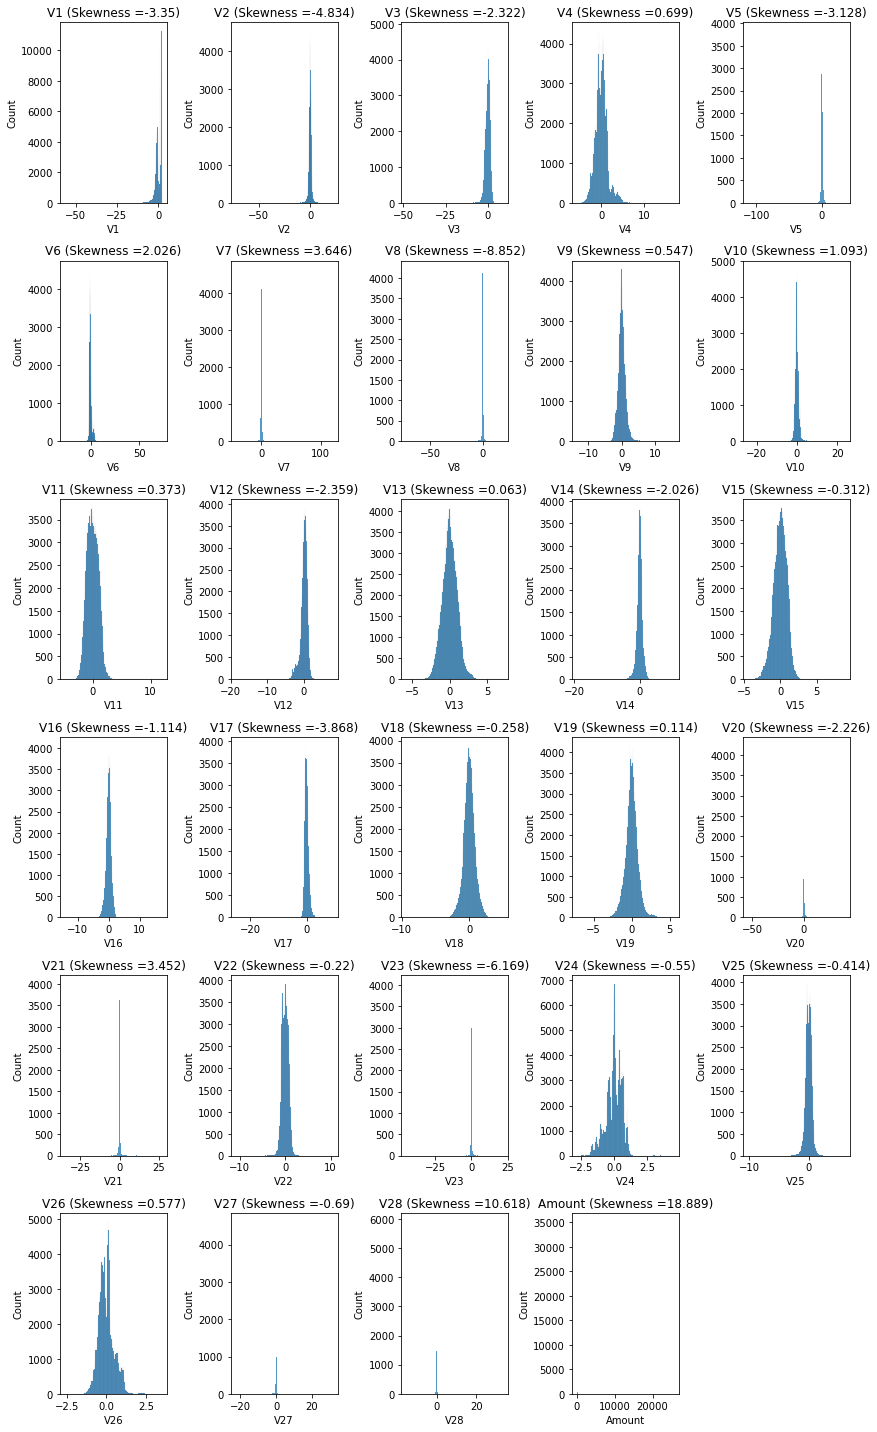

In [36]:
plot_skewness_histogram(X_train)

### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [37]:
# Yes you can see the Skewness in the data . 
#- Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
# Based on this https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
#Default is yeo-johnson and the other option is yeo-johnson 

#Parameters:
#method{‘yeo-johnson’, ‘box-cox’}, default=’yeo-johnson’
#The power transform method. Available methods are:

#‘yeo-johnson’ [1], works with positive and negative values

#‘box-cox’ [2], only works with strictly positive values

#standardizebool, default=True
#Set to True to apply zero-mean, unit-variance normalization to the transformed output.

#copybool, default=True
#Set to False to perform inplace computation during transformation.

#When you set standardize=True in PowerTransformer, it will first transform your data to have a mean of 0 and a standard deviation of 1, just like what the StandardScaler does. This standardization is applied before the power transformation.

#After standardization, the PowerTransformer performs the power transformation (Box-Cox or Yeo-Johnson) to make the data more Gaussian-like.


In [38]:
# Capture all Columns
cols = X_train.columns


# Importing PowerTransformer
from sklearn.preprocessing import PowerTransformer 

# Instantiate the powertransformer
pt = PowerTransformer(standardize=True, copy=False)

# Fit and transform the PT on training data
X_train[cols] = pt.fit_transform(X_train)

In [39]:
# Transform the test set as well 
X_test = pt.transform(X_test)

In [40]:
# you can see that the Amount are standardized so no need to standardize again
X_train.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,...,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05
mean,-4.534304e-17,1.704701e-17,-3.474389e-17,1.456164e-17,1.868403e-17,-1.160613e-17,-3.940556e-17,-7.300907e-18,-1.452071e-17,1.122229e-17,...,3.499184e-17,5.332288e-18,-2.172955e-17,-2.526896e-17,-1.653495e-17,1.281609e-17,-3.758009e-17,-1.185324e-17,-6.026581e-18,-7.314890e-16
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-8.423142e+00,-2.352211e+01,-1.293327e+01,-5.035996e+00,-7.147724e+01,-4.167707e+01,-3.564496e+01,-2.767072e+01,-1.630065e+01,-3.115911e+01,...,-6.559286e+01,-6.222180e+01,-1.327545e+01,-5.840873e+01,-3.539515e+00,-1.465122e+01,-8.026848e+00,-4.568541e+01,-6.006735e+01,-2.014105e+00
25%,-7.225495e-01,-4.534914e-01,-7.121168e-01,-5.677066e-01,-5.087889e-01,-5.565302e-01,-4.418839e-01,-2.757492e-01,-5.605366e-01,-4.737027e-01,...,-2.754652e-01,-3.009014e-01,-7.556592e-01,-2.735518e-01,-6.601130e-01,-6.327912e-01,-6.496852e-01,-1.844458e-01,-1.545649e-01,-7.457231e-01
50%,-2.500047e-01,-4.192011e-02,-2.492247e-02,6.338946e-02,-5.346213e-02,-1.158032e-01,3.494816e-02,-5.506119e-02,5.449009e-03,-4.744744e-02,...,-8.377897e-02,-2.352486e-02,-1.228170e-02,-2.987297e-02,-2.908084e-02,-6.087259e-03,-1.754824e-02,-6.842957e-03,4.421625e-02,2.568798e-02
75%,7.350218e-01,4.762444e-01,6.730424e-01,5.836669e-01,4.323553e-01,4.099482e-01,4.591928e-01,2.565753e-01,5.827192e-01,4.538194e-01,...,1.687240e-01,2.710607e-01,7.205103e-01,2.280991e-01,7.060150e-01,6.581175e-01,5.777305e-01,2.157626e-01,2.502191e-01,7.497848e-01
max,1.865925e+00,2.350533e+01,1.147201e+01,8.501222e+00,2.779986e+01,2.346877e+01,9.392283e+01,3.804417e+01,1.077233e+01,1.651112e+01,...,5.410452e+01,2.960456e+01,1.644871e+01,4.250414e+01,1.238716e+01,1.493682e+01,4.936779e+00,9.830702e+01,7.736510e+01,3.678522e+00


In [41]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
249927,-0.267697,0.404782,-0.037582,-0.495586,0.417461,-0.450219,0.677525,-0.079224,-0.119844,-0.170534,...,-0.052398,-0.305036,-0.796136,0.056456,-0.669016,-0.954144,0.386449,0.578464,0.267038,-0.619494
214082,1.167168,-0.201782,-1.385696,0.868101,0.434724,-0.791180,0.737052,-0.437967,-0.246955,0.508288,...,-0.042231,0.398622,0.722406,-0.385755,-0.641055,0.951240,-0.898773,-0.195537,-0.166521,1.119765
106005,-0.792373,-2.385479,-0.987745,0.403150,-1.478402,-0.554012,1.280349,-0.714879,-1.218243,0.119978,...,2.863557,0.486079,-1.922162,-1.734577,0.838645,-0.304635,1.660302,-0.783775,0.704921,2.265229
58619,-0.538573,0.640442,-0.551757,-0.515036,1.826026,2.172282,0.039457,0.777160,-0.250948,0.158587,...,0.289018,-0.251382,-0.976642,0.224379,1.768707,-1.469473,0.177960,0.016490,0.784726,-0.870972
191638,-0.596658,0.056559,0.052907,-1.351635,1.933233,2.527105,-0.156943,0.944995,0.474378,-0.229042,...,0.196280,0.245843,1.050549,-0.527474,1.382820,-0.198843,1.242931,0.173308,-0.093808,-0.870972


In [42]:
pd.DataFrame(X_test).describe()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
count,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,...,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000,85443.000000
mean,0.000508,0.003626,0.002661,-0.000805,-0.000500,-0.000172,0.000848,0.004654,-0.006078,-0.000960,...,0.004248,-0.001596,-0.001725,-0.003971,0.000760,0.003545,-0.000544,0.003029,-0.005220,-0.003818
std,0.997436,0.995017,0.998794,1.000201,0.985887,0.987052,0.970455,1.012351,0.999551,0.988359,...,0.976567,0.971746,0.998126,0.997871,1.002710,0.998903,1.000351,0.959526,0.993745,1.001301
min,-6.695965,-17.528582,-9.817724,-4.952641,-26.343795,-29.771804,-27.151764,-21.139750,-12.814130,-27.790012,...,-34.169088,-39.191568,-10.923127,-43.705220,-3.528194,-12.672744,-5.239353,-21.138137,-30.985384,-2.014105
25%,-0.723664,-0.449848,-0.711113,-0.571756,-0.507654,-0.554910,-0.442588,-0.276190,-0.569136,-0.474893,...,-0.275182,-0.300618,-0.756677,-0.272617,-0.658218,-0.633591,-0.651024,-0.185711,-0.155251,-0.762270
50%,-0.249066,-0.039443,-0.026332,0.065497,-0.052032,-0.116700,0.034086,-0.057228,0.002561,-0.046779,...,-0.082754,-0.025106,-0.010593,-0.032875,-0.030001,-0.004588,-0.017900,-0.007080,0.043993,0.025424
75%,0.735786,0.473055,0.676253,0.582553,0.434433,0.409152,0.457443,0.257781,0.574200,0.448688,...,0.168839,0.270398,0.719829,0.226654,0.708801,0.662245,0.577883,0.215437,0.250502,0.744644
max,1.869233,18.369143,4.151762,6.425007,22.828204,10.149528,34.553965,33.963705,6.815341,10.183124,...,35.718120,29.604561,12.773167,43.417052,10.476356,19.053707,4.519774,30.113074,53.826811,3.368811


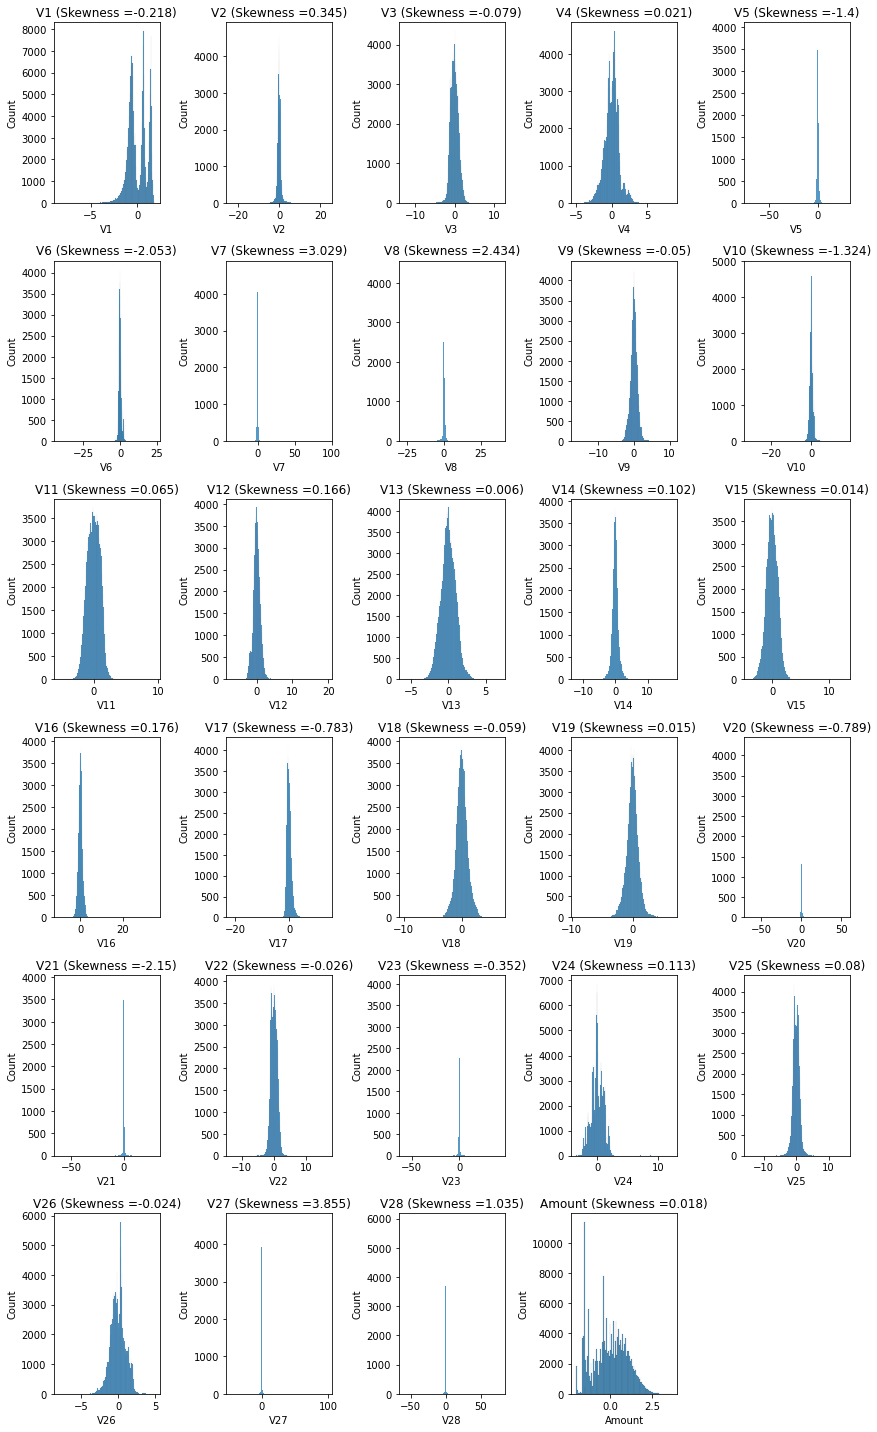

In [43]:
# plot the histogram of a variable from the dataset again to see the result 
plot_skewness_histogram(X_train)

<a id='build'></a>

## Model building / hyperparameter tuning / Model Evaluation 

### Model Building
### - Build different models on the imbalanced dataset and see the result

In [44]:
#!pip install xgboost

# Test each model and store the metrics in the DataFrame
#for model_name, (model, hyperparameters) in models.items():
#    metrics_info = test_classification_model(model,X_train, y_train,hyperparameters=hyperparameters)
#    metrics_df = metrics_df.append({'Model': model_name, **metrics_info}, ignore_index=True)
#    display(metrics_df)
# Display the metrics DataFrame
#print("Final Metrics and the Model information")
#print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX\n\n")
#display(metrics_df.sort_values(by=['ROC AUC'],ascending=False).reset_index(drop=True))

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Define the models to test with Hyperparameter 
models = {
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [10, 50],
        'max_depth': [ 10,20,30]
    }),
    'Logistic Regression': (LogisticRegression(solver='lbfgs', max_iter=1000), {
        'C': [0.1, 1]
    }),
    'XGBoost' : (XGBClassifier(max_depth=2, n_estimators=200),{
                'learning_rate': [0.2, 0.6],
                'subsample': [0.3, 0.6, 0.9]
    }),
    'DecisionTree' : (DecisionTreeClassifier(),{
                'max_depth': range(5, 15, 5),
                'min_samples_leaf': range(50, 150, 50),
                'min_samples_split': range(50, 150, 50),

    }),
    'KNN' : (KNeighborsClassifier(),{
        'n_neighbors': [3, 5, 7],  # You can adjust the number of neighbors to search
        'weights': ['uniform', 'distance'],
    }),

}

In [46]:
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC,Threshold,ROC AUC - Test Data


Processing for the Model : RandomForestClassifier() 
Splitting train and test for the Model : RandomForestClassifier() 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : RandomForestClassifier()  with hyperparamer {'n_estimators': [10, 50], 'max_depth': [10, 20, 30]}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.6s
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.8s
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.5s
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.5s
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=  27.1s
[CV] END ......................max_depth=10, n_estimators=50; total time=  27.6s
[CV] END ......................max_depth=10, n_estimators=50; total time= 

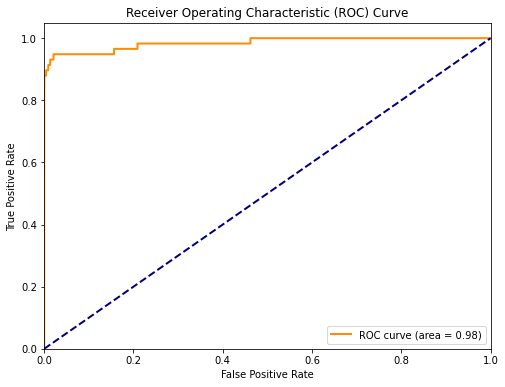

The CV results for the model RandomForestClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.523999,0.143059,0.027054,0.002348,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.975919,0.937390,0.955639,...,0.957935,0.012424,2,0.994161,0.987704,0.993023,0.992738,0.996194,0.992764,2.806396e-03
1,27.430288,0.465349,0.086341,0.002515,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.964581,0.968288,0.969141,...,0.967231,0.011430,1,0.998898,0.999114,0.996755,0.995414,0.998884,0.997813,1.475823e-03
2,7.971621,0.472100,0.032820,0.001561,20,10,"{'max_depth': 20, 'n_estimators': 10}",0.895830,0.945740,0.924618,...,0.936949,0.025056,4,1.000000,0.999999,0.999999,0.999999,0.999997,0.999999,1.095446e-06
3,38.156360,1.686952,0.113088,0.008869,20,50,"{'max_depth': 20, 'n_estimators': 50}",0.913011,0.924161,0.963450,...,0.946454,0.024465,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.965068e-17
4,8.086446,0.636428,0.030891,0.000891,30,10,"{'max_depth': 30, 'n_estimators': 10}",0.893661,0.916327,0.948873,...,0.922161,0.022287,6,0.999999,0.999999,0.999999,1.000000,0.999998,0.999999,6.738059e-07
5,39.486484,1.253874,0.116468,0.003062,30,50,"{'max_depth': 30, 'n_estimators': 50}",0.912245,0.932291,0.948307,...,0.935693,0.018710,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00


The Metrics for the best score 0.9672305414066364  and Best Estimator RandomForestClassifier(max_depth=10, n_estimators=50) 
Processing for the Model : LogisticRegression(max_iter=1000) 
Splitting train and test for the Model : LogisticRegression(max_iter=1000) 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : LogisticRegression(max_iter=1000)  with hyperparamer {'C': [0.1, 1]}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..............................................C=0.1; total time=   0.8s
[CV] END ..............................................C=0.1; total time=   0.5s
[CV] END ..............................................C=0.1; total time=   0.5s
[CV] END ..............................................C=0.1; total time=   0.7s
[CV] END ..............................................C=0.1; total time=   0.6s
[CV] END ................................................C=1; total time=   0.9s
[CV] END ................................

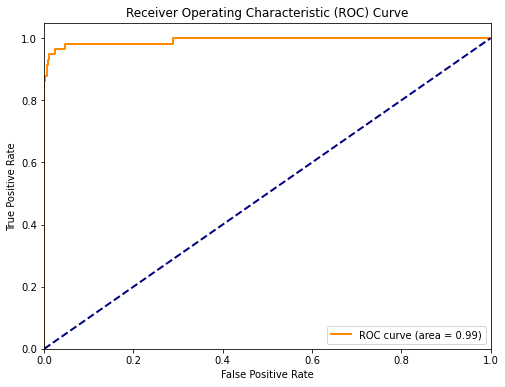

The CV results for the model LogisticRegression(max_iter=1000) 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.618953,0.111375,0.012894,0.002540,0.1,{'C': 0.1},0.985767,0.978822,0.972201,0.993589,...,0.981163,0.007671,1,0.985268,0.985256,0.986053,0.983158,0.988635,0.985674,0.001765
1,0.749975,0.106264,0.010196,0.000353,1,{'C': 1},0.983033,0.977001,0.971953,0.994025,...,0.980299,0.007741,2,0.985043,0.984143,0.985419,0.982550,0.988130,0.985057,0.001827


The Metrics for the best score 0.9811629063639288  and Best Estimator LogisticRegression(C=0.1, max_iter=1000) 
Processing for the Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 
Splitting train and test for the Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
    

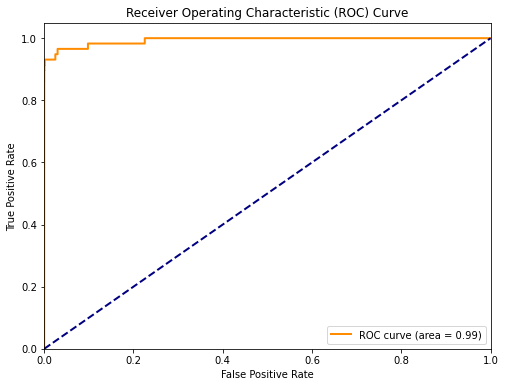

The CV results for the model XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.723688,0.146242,0.032569,0.006687,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.962190,0.974564,0.978849,...,0.977082,0.010484,3,0.999894,0.999907,0.999827,0.999474,0.999617,0.999744,0.000170
1,1.669310,0.058380,0.034787,0.010617,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.974586,0.967476,0.978109,...,0.976202,0.011126,4,0.999991,0.999984,0.999919,0.999937,0.999981,0.999963,0.000029
2,1.559472,0.094864,0.032068,0.007014,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.975552,0.975582,0.986912,...,0.980550,0.009061,1,0.999990,0.999965,0.999952,0.999922,0.999984,0.999963,0.000024
3,1.697752,0.045948,0.039037,0.008811,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.944875,0.974370,0.965302,...,0.966210,0.014991,6,0.999998,0.999995,0.999985,0.999986,0.999999,0.999993,0.000006
4,1.481527,0.190422,0.030289,0.007668,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.973699,0.977909,0.967905,...,0.973691,0.013751,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,1.628725,0.116978,0.030811,0.009120,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.967177,0.982916,0.977524,...,0.977265,0.012424,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


The Metrics for the best score 0.9805500090234173  and Best Estimator XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 
Processing for the Model : DecisionTreeClassifier() 
Splitting train and test for the Model : DecisionTreeClassifier() 
Creating KFold object with 5 splits
Configuring hyper pa

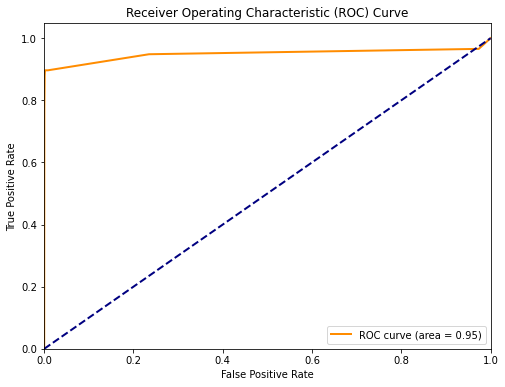

The CV results for the model DecisionTreeClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.234434,0.011662,0.009614,0.000481,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.910311,0.916369,...,0.926424,0.024517,8,0.957599,0.931110,0.958481,0.947409,0.931793,0.945278,0.011944
1,2.247521,0.020331,0.009965,0.000799,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.910311,0.916369,...,0.929859,0.021007,5,0.957599,0.931110,0.958481,0.947409,0.931793,0.945278,0.011944
2,2.218291,0.023624,0.009050,0.000196,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.909744,0.916112,...,0.928962,0.018495,6,0.957217,0.935319,0.961324,0.947203,0.965531,0.953319,0.010861
3,2.225515,0.016376,0.009365,0.000582,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.909744,0.916112,...,0.932347,0.019732,4,0.957217,0.935319,0.961324,0.947203,0.965531,0.953319,0.010861
4,4.387827,0.021759,0.011042,0.002429,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.921724,0.948717,...,0.933770,0.029618,3,0.988162,0.978139,0.985983,0.972753,0.967570,0.978522,0.007771
5,4.431047,0.064801,0.010250,0.000673,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.921722,0.948659,...,0.927006,0.033425,7,0.988158,0.978139,0.985983,0.972753,0.967570,0.978521,0.007770
6,4.443175,0.050346,0.010013,0.000724,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.921338,0.934529,...,0.941506,0.012142,2,0.989927,0.982140,0.989723,0.972257,0.992426,0.985295,0.007374
7,4.344398,0.031175,0.009794,0.000213,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.921709,0.934539,...,0.941595,0.012024,1,0.989937,0.982140,0.989723,0.972257,0.992426,0.985297,0.007375


The Metrics for the best score 0.9415949340313723  and Best Estimator DecisionTreeClassifier(max_depth=10, min_samples_leaf=100,
                       min_samples_split=100) 
Processing for the Model : KNeighborsClassifier() 
Splitting train and test for the Model : KNeighborsClassifier() 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : KNeighborsClassifier()  with hyperparamer {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................n_neighbors=3, weights=uniform; total time=   4.5s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   4.0s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   4.1s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   4.0s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   4.1s
[CV] END ....................n_neighbors=3, weights=dista

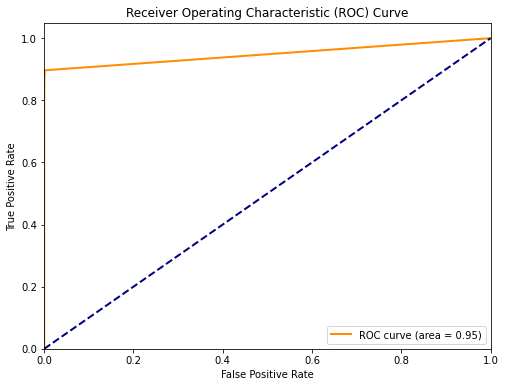

The CV results for the model KNeighborsClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.036361,0.011199,4.114430,0.184452,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.884470,0.899818,0.906687,...,0.908731,0.029191,6,0.999951,0.999948,0.999943,0.999935,0.999951,0.999946,6.251817e-06
1,0.031424,0.004293,4.085021,0.055255,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.884472,0.899825,0.906689,...,0.908737,0.029193,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
2,0.027724,0.002123,4.139718,0.235213,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.884416,0.908129,0.923609,...,0.913756,0.029238,2,0.999910,0.999903,0.999883,0.999876,0.999905,0.999895,1.340101e-05
3,0.029822,0.003176,4.253009,0.213564,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.884429,0.908127,0.923614,...,0.913768,0.029239,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
4,0.028231,0.001373,4.087324,0.134988,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.884364,0.908117,0.923559,...,0.913720,0.029239,4,0.999872,0.999866,0.999841,0.999816,0.999863,0.999852,2.050247e-05
5,0.028333,0.001589,3.995019,0.052472,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.884390,0.908127,0.923572,...,0.913741,0.029241,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.965068e-17


The Metrics for the best score 0.9137677477248495  and Best Estimator KNeighborsClassifier(weights='distance') 
Final Metrics and the Model information
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX




,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC,Threshold,ROC AUC - Test Data,sensitivity,specificity
0,XGBoost,0.999649,0.923077,0.827586,0.872727,"XGBClassifier(base_score=None, booster=None, c...","[[39811, 4], [10, 48]]",0.993420,NaN,NaN,0.827586,0.999900
1,Logistic Regression,0.999273,0.822222,0.637931,0.718447,"LogisticRegression(C=0.1, max_iter=1000)","[[39807, 8], [21, 37]]",0.993083,NaN,NaN,0.637931,0.999799
2,Random Forest,0.999624,0.938776,0.793103,0.859813,"(DecisionTreeClassifier(max_depth=10, max_feat...","[[39812, 3], [12, 46]]",0.984888,NaN,NaN,0.793103,0.999925
3,DecisionTree,0.999323,0.762712,0.775862,0.769231,"DecisionTreeClassifier(max_depth=10, min_sampl...","[[39801, 14], [13, 45]]",0.949039,NaN,NaN,0.775862,0.999648
4,KNN,0.999599,0.903846,0.810345,0.854545,KNeighborsClassifier(weights='distance'),"[[39810, 5], [11, 47]]",0.948178,NaN,NaN,0.810345,0.999874


In [47]:
metrics_df = create_classification_report(models,metrics_df,X_train, y_train)

AUC score for the Model Random Forest : 0.9669047249371419
Threshold for the model Random Forest  = 0.0004298932025328339 
RoC curve for model Random Forest 


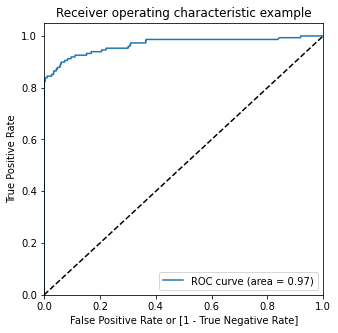

AUC score for the Model Logistic Regression : 0.9673152635606472
Threshold for the model Logistic Regression  = 0.0034452699664573503 
RoC curve for model Logistic Regression 


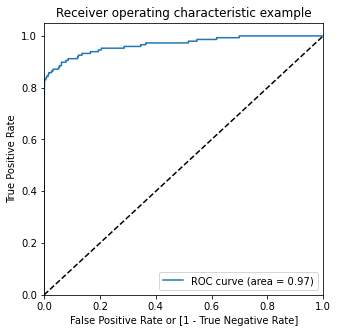

AUC score for the Model XGBoost : 0.9709158041328744
Threshold for the model XGBoost  = 0.0012699400540441275 
RoC curve for model XGBoost 


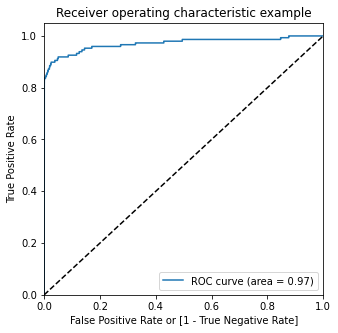

AUC score for the Model DecisionTree : 0.9256967472191108
Threshold for the model DecisionTree  = 0.04 
RoC curve for model DecisionTree 


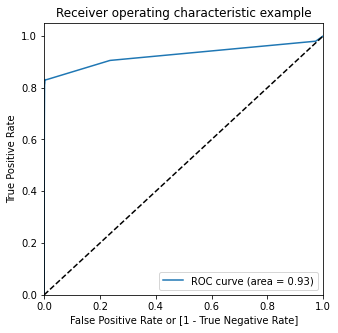

AUC score for the Model KNN : 0.9187726063598037
Threshold for the model KNN  = 0.18331400228363656 
RoC curve for model KNN 


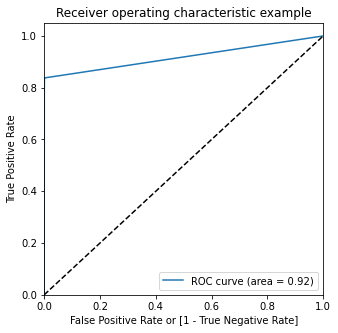

In [48]:
metrics_df = create_model_threshold(models,metrics_df)

In [49]:
display(metrics_df.sort_values(by=['ROC AUC'],ascending=False).reset_index(drop=True))

,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC,Threshold,ROC AUC - Test Data,sensitivity,specificity
0,XGBoost,0.999649,0.923077,0.827586,0.872727,"XGBClassifier(base_score=None, booster=None, c...","[[39811, 4], [10, 48]]",0.993420,0.001270,0.970916,0.827586,0.999900
1,Logistic Regression,0.999273,0.822222,0.637931,0.718447,"LogisticRegression(C=0.1, max_iter=1000)","[[39807, 8], [21, 37]]",0.993083,0.003445,0.967315,0.637931,0.999799
2,Random Forest,0.999624,0.938776,0.793103,0.859813,"(DecisionTreeClassifier(max_depth=10, max_feat...","[[39812, 3], [12, 46]]",0.984888,0.000430,0.966905,0.793103,0.999925
3,DecisionTree,0.999323,0.762712,0.775862,0.769231,"DecisionTreeClassifier(max_depth=10, min_sampl...","[[39801, 14], [13, 45]]",0.949039,0.040000,0.925697,0.775862,0.999648
4,KNN,0.999599,0.903846,0.810345,0.854545,KNeighborsClassifier(weights='distance'),"[[39810, 5], [11, 47]]",0.948178,0.183314,0.918773,0.810345,0.999874


We can see that among all the models we tried (Logistic, XGBoost, Decision Tree, and Random Forest), almost all of them have performed well.
More specifically Logistic regression ( roc auc :0.993083) and XGBoost ( roc auc :0.993420 ) performed best in terms of ROC-AUC score.
But if we were to choose one of them , we can go for the best as XGBoost which gives us best ROC score.

NOTE: You should see that best_model is of type RandomForestClassifier, and it should display the parameters of the random forest.

The reason it may show "Decision Tree" in the output is due to the way scikit-learn structures its code. The DecisionTreeClassifier is the base class for individual decision trees used within random forests, and it's possible that the naming convention is inherited from that.

In summary, seeing "Decision Tree" in the output of GridSearchCV when accessing the best_estimator_ attribute is not an issue. It's just a label used by scikit-learn, and the returned model is still a random forest with the best hyperparameters.

### Print the important features of the best model to understand the dataset
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

Top var = 10
2nd Top var = 14
3rd Top var = 17


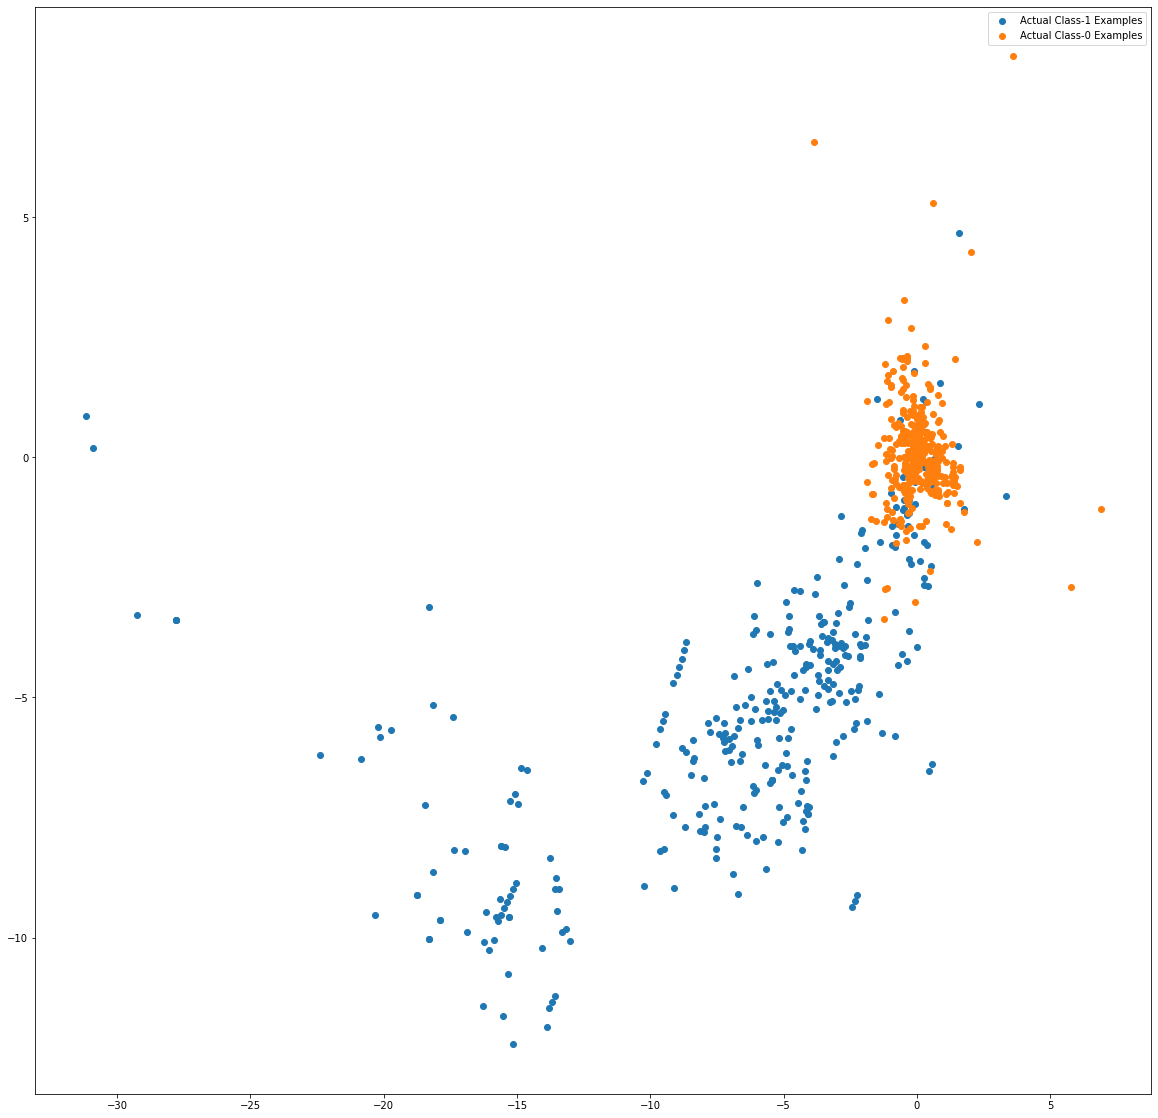

In [50]:
#logistic regression does not have the feature_importance and you canfind by Coefficient Magnitude/Hypothesis Testing and Regularization etc.. 
# Since we got the best_model as XGBoost we can find using the below 
best_model_xgb = metrics_df[metrics_df['Model'] == 'XGBoost']['Best_Model'].values[0]
var_imp = []
for i in best_model_xgb.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(best_model_xgb.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(best_model_xgb.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(best_model_xgb.feature_importances_)[-3])+1)

# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(best_model_xgb.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(best_model_xgb.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()
plt.show()

## Model building with balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

## RandomOverSampler

Random Oversampling (ROS) is a technique used to address class imbalance in a binary classification problem. It helps balance the class distribution by randomly duplicating instances from the minority class until the class distribution is approximately equal to that of the majority class. While ROS does increase the number of minority class samples and can improve the classifier's ability to learn from the minority class, it may not always be the best approach, and it has some potential drawbacks:

Overfitting: Random Oversampling can lead to overfitting. By duplicating instances from the minority class, you might risk making the model memorize the training data, which can result in poor generalization to unseen data.

Loss of Information: When you oversample, you may introduce duplicated information, leading to a loss of diversity in the data. This can affect the model's ability to capture the underlying patterns and may not always result in a better classifier.

Increased Training Time: With more instances in the dataset, the training time of your model may increase.

Data Leakage: If you use the same data for both training and testing, you might introduce data leakage, as the same instances may appear in both sets. Cross-validation is often used to mitigate this issue.

Impact on the Decision Boundary: Oversampling can influence the decision boundary of the classifier, potentially making it less conservative in classifying new data points.

Random Oversampling can be effective in certain situations, especially when you have a small dataset and cannot collect more samples of the minority class. However, it's essential to be aware of the potential drawbacks and to experiment with other techniques like Synthetic Minority Over-sampling Technique (SMOTE) and Adaptive Synthetic Sampling (ADASYN) to see if they provide better results for your specific problem. The choice of the method should depend on the characteristics of your data and the performance of the resulting model.

In [51]:
X_ro_resampled, y_ro_resampled = perform_resampling(X_train , y_train, method='random')

In [52]:
y_ro_resampled.value_counts()

0    199020
1    199020
Name: Class, dtype: int64

In [53]:
X_ro_resampled.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.267697,0.404782,-0.037582,-0.495586,0.417461,-0.450219,0.677525,-0.079224,-0.119844,-0.170534,...,-0.052398,-0.305036,-0.796136,0.056456,-0.669016,-0.954144,0.386449,0.578464,0.267038,-0.619494
1,1.167168,-0.201782,-1.385696,0.868101,0.434724,-0.791180,0.737052,-0.437967,-0.246955,0.508288,...,-0.042231,0.398622,0.722406,-0.385755,-0.641055,0.951240,-0.898773,-0.195537,-0.166521,1.119765
2,-0.792373,-2.385479,-0.987745,0.403150,-1.478402,-0.554012,1.280349,-0.714879,-1.218243,0.119978,...,2.863557,0.486079,-1.922162,-1.734577,0.838645,-0.304635,1.660302,-0.783775,0.704921,2.265229
3,-0.538573,0.640442,-0.551757,-0.515036,1.826026,2.172282,0.039457,0.777160,-0.250948,0.158587,...,0.289018,-0.251382,-0.976642,0.224379,1.768707,-1.469473,0.177960,0.016490,0.784726,-0.870972
4,-0.596658,0.056559,0.052907,-1.351635,1.933233,2.527105,-0.156943,0.944995,0.474378,-0.229042,...,0.196280,0.245843,1.050549,-0.527474,1.382820,-0.198843,1.242931,0.173308,-0.093808,-0.870972


## Model Building - RandomOverSampler
- Build different models on the balanced dataset and see the result

In [54]:
models = {
    'Random Forest-ROS': (RandomForestClassifier(), {
        'n_estimators': [10, 50],
        'max_depth': [ 10,20,30]
    }),
    'Logistic Regression-ROS': (LogisticRegression(solver='lbfgs', max_iter=1000), {
        'C': [0.1, 1]
    }),
    'XGBoost-ROS' : (XGBClassifier(max_depth=2, n_estimators=200),{
                'learning_rate': [0.2, 0.6],
                'subsample': [0.3, 0.6, 0.9]
    }),
    'DecisionTree-ROS' : (DecisionTreeClassifier(),{
                'max_depth': range(5, 15, 5),
                'min_samples_leaf': range(50, 150, 50),
                'min_samples_split': range(50, 150, 50),

    }),
    'KNN-ROS' : (KNeighborsClassifier(),{
        'n_neighbors': [3, 5, 7],  # You can adjust the number of neighbors to search
        'weights': ['uniform', 'distance'],
    }),
}

Processing for the Model : RandomForestClassifier() 
Splitting train and test for the Model : RandomForestClassifier() 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : RandomForestClassifier()  with hyperparamer {'n_estimators': [10, 50], 'max_depth': [10, 20, 30]}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......................max_depth=10, n_estimators=10; total time=   7.2s
[CV] END ......................max_depth=10, n_estimators=10; total time=   6.8s
[CV] END ......................max_depth=10, n_estimators=10; total time=   6.6s
[CV] END ......................max_depth=10, n_estimators=10; total time=   7.1s
[CV] END ......................max_depth=10, n_estimators=10; total time=   7.1s
[CV] END ......................max_depth=10, n_estimators=50; total time=  35.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=  35.5s
[CV] END ......................max_depth=10, n_estimators=50; total time= 

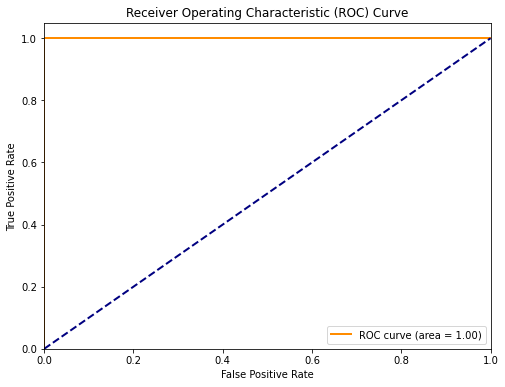

The CV results for the model RandomForestClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,6.919335,0.245356,0.060867,0.001698,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.999974,0.999887,0.999911,...,0.999900,5.240789e-05,6,0.999970,0.999966,0.999974,0.999902,0.999820,0.999927,5.953526e-05
1,34.919572,0.323349,0.212239,0.004140,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.999991,0.999918,0.999953,...,0.999963,2.564859e-05,5,0.999989,0.999984,0.999990,0.999981,0.999986,0.999986,3.430230e-06
2,7.743822,0.161301,0.068497,0.004052,20,10,"{'max_depth': 20, 'n_estimators': 10}",1.000000,0.999981,0.999979,...,0.999984,8.052005e-06,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
3,36.988568,1.252202,0.238527,0.014327,20,50,"{'max_depth': 20, 'n_estimators': 50}",1.000000,0.999990,1.000000,...,0.999998,4.099042e-06,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.965068e-17
4,7.100656,0.189766,0.066104,0.003766,30,10,"{'max_depth': 30, 'n_estimators': 10}",1.000000,0.999969,0.999984,...,0.999991,1.252366e-05,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
5,37.734569,1.067235,0.241116,0.016139,30,50,"{'max_depth': 30, 'n_estimators': 50}",1.000000,1.000000,1.000000,...,1.000000,4.965068e-17,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00


The Metrics for the best score 1.0  and Best Estimator RandomForestClassifier(max_depth=30, n_estimators=50) 
Processing for the Model : LogisticRegression(max_iter=1000) 
Splitting train and test for the Model : LogisticRegression(max_iter=1000) 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : LogisticRegression(max_iter=1000)  with hyperparamer {'C': [0.1, 1]}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..............................................C=0.1; total time=   1.6s
[CV] END ..............................................C=0.1; total time=   1.3s
[CV] END ..............................................C=0.1; total time=   1.4s
[CV] END ..............................................C=0.1; total time=   1.3s
[CV] END ..............................................C=0.1; total time=   1.6s
[CV] END ................................................C=1; total time=   1.4s
[CV] END ...............................................

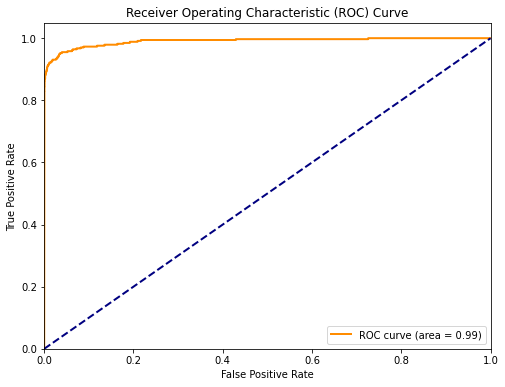

The CV results for the model LogisticRegression(max_iter=1000) 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.404048,0.133515,0.026229,0.005865,0.1,{'C': 0.1},0.990757,0.990407,0.990295,0.990470,...,0.990411,0.000209,2,0.990341,0.990481,0.990482,0.990369,0.990486,0.990432,0.000063
1,1.247070,0.088286,0.025298,0.005159,1,{'C': 1},0.990772,0.990417,0.990314,0.990486,...,0.990427,0.000207,1,0.990360,0.990498,0.990500,0.990389,0.990505,0.990450,0.000063


The Metrics for the best score 0.990427342012158  and Best Estimator LogisticRegression(C=1, max_iter=1000) 
Processing for the Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 
Splitting train and test for the Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
       

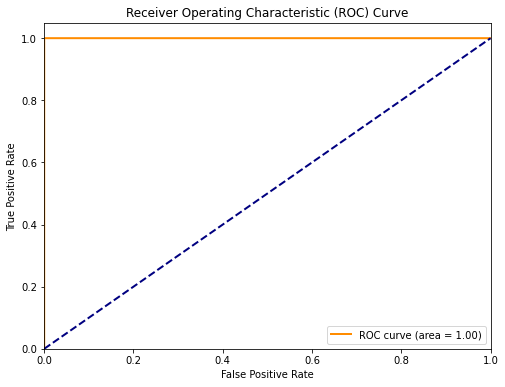

The CV results for the model XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.273670,0.230036,0.051657,0.006185,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.999940,0.999862,0.999895,...,0.999912,0.000032,4,0.999939,0.999934,0.999935,0.999935,0.999916,0.999932,8.164001e-06
1,2.922210,0.511383,0.046534,0.004474,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.999937,0.999880,0.999868,...,0.999909,0.000032,5,0.999914,0.999941,0.999927,0.999923,0.999911,0.999923,1.072740e-05
2,3.177852,0.197673,0.053460,0.007197,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.999928,0.999854,0.999880,...,0.999906,0.000034,6,0.999912,0.999926,0.999929,0.999929,0.999913,0.999922,7.571305e-06
3,3.063438,0.021396,0.050626,0.003288,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.999962,0.999963,0.999931,...,0.999967,0.000022,3,0.999999,0.999999,1.000000,1.000000,1.000000,0.999999,5.735065e-07
4,3.075192,0.107058,0.047188,0.002011,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.999962,0.999984,0.999966,...,0.999980,0.000014,2,1.000000,1.000000,1.000000,1.000000,0.999999,1.000000,4.895409e-07
5,3.017306,0.122678,0.051672,0.007783,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.999973,0.999975,0.999970,...,0.999982,0.000011,1,1.000000,1.000000,1.000000,1.000000,0.999999,1.000000,5.666834e-07


The Metrics for the best score 0.9999817198238107  and Best Estimator XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 
Processing for the Model : DecisionTreeClassifier() 
Splitting train and test for the Model : DecisionTreeClassifier() 
Creating KFold object with 5 splits
Configuring hyper pa

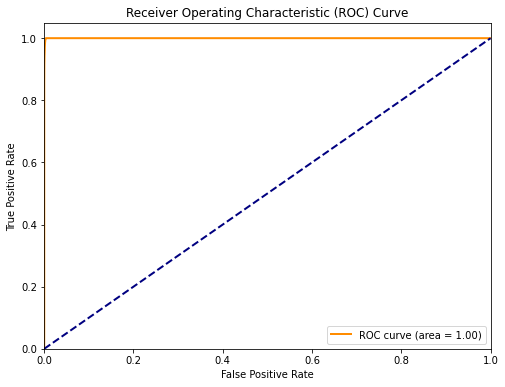

The CV results for the model DecisionTreeClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.925066,0.174515,0.021898,0.000409,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.995096,0.993753,...,0.994446,0.000461,5,0.994887,0.994033,0.994006,0.995005,0.994775,0.994541,0.000432
1,2.920401,0.043723,0.022412,0.002109,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.995096,0.993753,...,0.994446,0.000461,5,0.994887,0.994033,0.994006,0.995005,0.994775,0.994541,0.000432
2,2.969311,0.117740,0.021551,0.001342,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.994950,0.993593,...,0.994332,0.000484,7,0.994704,0.993867,0.993802,0.994891,0.994751,0.994403,0.000468
3,2.852607,0.073171,0.022605,0.002878,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.994950,0.993593,...,0.994332,0.000484,7,0.994704,0.993867,0.993802,0.994891,0.994751,0.994403,0.000468
4,3.682681,0.069401,0.023215,0.003396,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.999828,0.999633,...,0.999651,0.000090,1,0.999841,0.999841,0.999878,0.999840,0.999807,0.999841,0.000023
5,3.745855,0.063972,0.021383,0.000624,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.999806,0.999697,...,0.999630,0.000120,2,0.999841,0.999841,0.999878,0.999842,0.999807,0.999842,0.000023
6,3.701568,0.063464,0.022203,0.000820,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.999408,0.999622,...,0.999480,0.000087,4,0.999771,0.999744,0.999739,0.999819,0.999787,0.999772,0.000030
7,3.808556,0.099359,0.022969,0.001465,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.999381,0.999621,...,0.999491,0.000086,3,0.999771,0.999742,0.999739,0.999819,0.999787,0.999772,0.000030


The Metrics for the best score 0.9996513008966481  and Best Estimator DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50) 
Processing for the Model : KNeighborsClassifier() 
Splitting train and test for the Model : KNeighborsClassifier() 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : KNeighborsClassifier()  with hyperparamer {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................n_neighbors=3, weights=uniform; total time=  16.0s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  16.6s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  17.9s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  16.5s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  16.4s
[CV] END ....................n_neighbors=3, weights=distance; total time=  16.5s
[

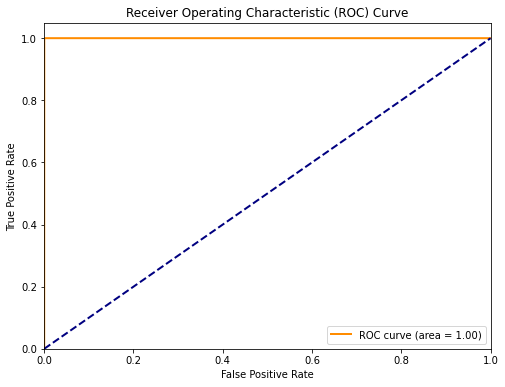

The CV results for the model KNeighborsClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.081298,0.020379,16.591982,0.641282,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.999858,0.999812,0.999764,...,0.999837,0.000044,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.067044,0.010406,16.330689,0.459354,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.999858,0.999812,0.999764,...,0.999837,0.000044,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.063498,0.006922,15.772754,0.113983,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.999858,0.999812,0.999764,...,0.999837,0.000044,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.058143,0.003574,15.735642,0.196369,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.999858,0.999812,0.999764,...,0.999837,0.000044,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.063000,0.010230,15.758589,0.304592,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.999858,0.999812,0.999764,...,0.999837,0.000044,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,0.057354,0.001915,15.705161,0.142073,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.999858,0.999812,0.999764,...,0.999837,0.000044,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0


The Metrics for the best score 0.9998366738395383  and Best Estimator KNeighborsClassifier(n_neighbors=3) 
Final Metrics and the Model information
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX




,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC,Threshold,ROC AUC - Test Data,sensitivity,specificity
0,Random Forest-ROS,0.999962,0.999925,1.000000,0.999962,"(DecisionTreeClassifier(max_depth=30, max_feat...","[[39833, 3], [0, 39772]]",1.000000,NaN,NaN,1.000000,0.999925
1,XGBoost-ROS,0.999837,0.999673,1.000000,0.999837,"XGBClassifier(base_score=None, booster=None, c...","[[39823, 13], [0, 39772]]",0.999995,NaN,NaN,1.000000,0.999674
2,KNN-ROS,0.999686,0.999372,1.000000,0.999686,KNeighborsClassifier(n_neighbors=3),"[[39811, 25], [0, 39772]]",0.999912,NaN,NaN,1.000000,0.999372
3,DecisionTree-ROS,0.998179,0.996367,1.000000,0.998180,"DecisionTreeClassifier(max_depth=10, min_sampl...","[[39691, 145], [0, 39772]]",0.999798,NaN,NaN,1.000000,0.996360
4,XGBoost,0.999649,0.923077,0.827586,0.872727,"XGBClassifier(base_score=None, booster=None, c...","[[39811, 4], [10, 48]]",0.993420,0.001270,0.970916,0.827586,0.999900
5,Logistic Regression,0.999273,0.822222,0.637931,0.718447,"LogisticRegression(C=0.1, max_iter=1000)","[[39807, 8], [21, 37]]",0.993083,0.003445,0.967315,0.637931,0.999799
6,Logistic Regression-ROS,0.953434,0.974927,0.930730,0.952316,"LogisticRegression(C=1, max_iter=1000)","[[38884, 952], [2755, 37017]]",0.990257,NaN,NaN,0.930730,0.976102
7,Random Forest,0.999624,0.938776,0.793103,0.859813,"(DecisionTreeClassifier(max_depth=10, max_feat...","[[39812, 3], [12, 46]]",0.984888,0.000430,0.966905,0.793103,0.999925
8,DecisionTree,0.999323,0.762712,0.775862,0.769231,"DecisionTreeClassifier(max_depth=10, min_sampl...","[[39801, 14], [13, 45]]",0.949039,0.040000,0.925697,0.775862,0.999648
9,KNN,0.999599,0.903846,0.810345,0.854545,KNeighborsClassifier(weights='distance'),"[[39810, 5], [11, 47]]",0.948178,0.183314,0.918773,0.810345,0.999874


In [55]:
metrics_df = create_classification_report(models,metrics_df,X_ro_resampled, y_ro_resampled)

AUC score for the Model Random Forest-ROS : 0.9309198758521696
Threshold for the model Random Forest-ROS  = 0.02 
RoC curve for model Random Forest-ROS 


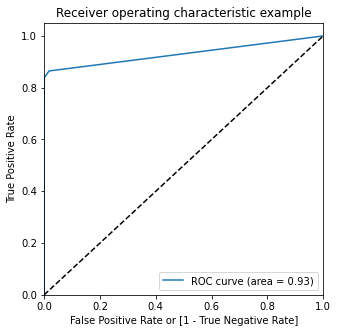

AUC score for the Model Logistic Regression-ROS : 0.9705106126115564
Threshold for the model Logistic Regression-ROS  = 0.4286775805983271 
RoC curve for model Logistic Regression-ROS 


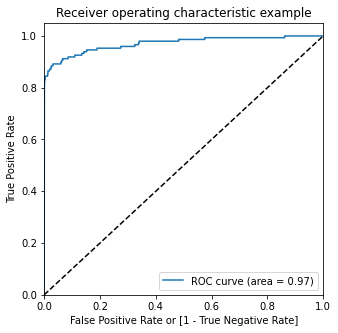

AUC score for the Model XGBoost-ROS : 0.973316138108916
Threshold for the model XGBoost-ROS  = 0.0006138587486930192 
RoC curve for model XGBoost-ROS 


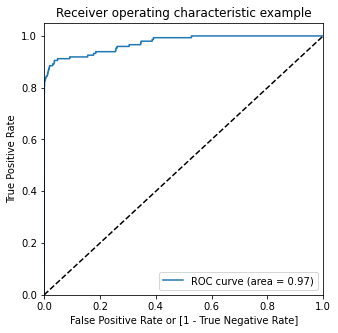

AUC score for the Model DecisionTree-ROS : 0.8979266710288457
Threshold for the model DecisionTree-ROS  = 0.842391304347826 
RoC curve for model DecisionTree-ROS 


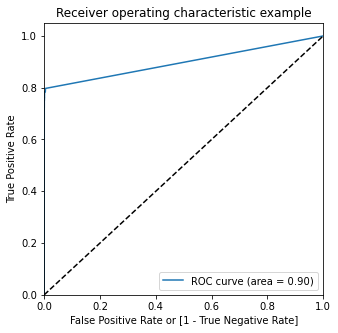

AUC score for the Model KNN-ROS : 0.9119925600024082
Threshold for the model KNN-ROS  = 0.3333333333333333 
RoC curve for model KNN-ROS 


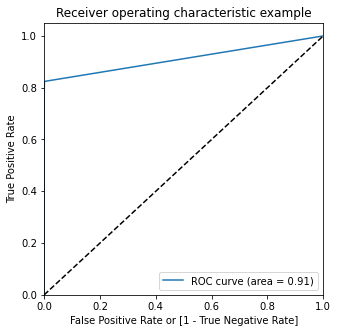

In [56]:
metrics_df = create_model_threshold(models,metrics_df)

In [57]:
display(metrics_df.sort_values(by=['ROC AUC'],ascending=False).reset_index(drop=True))

,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC,Threshold,ROC AUC - Test Data,sensitivity,specificity
0,Random Forest-ROS,0.999962,0.999925,1.000000,0.999962,"(DecisionTreeClassifier(max_depth=30, max_feat...","[[39833, 3], [0, 39772]]",1.000000,0.020000,0.930920,1.000000,0.999925
1,XGBoost-ROS,0.999837,0.999673,1.000000,0.999837,"XGBClassifier(base_score=None, booster=None, c...","[[39823, 13], [0, 39772]]",0.999995,0.000614,0.973316,1.000000,0.999674
2,KNN-ROS,0.999686,0.999372,1.000000,0.999686,KNeighborsClassifier(n_neighbors=3),"[[39811, 25], [0, 39772]]",0.999912,0.333333,0.911993,1.000000,0.999372
3,DecisionTree-ROS,0.998179,0.996367,1.000000,0.998180,"DecisionTreeClassifier(max_depth=10, min_sampl...","[[39691, 145], [0, 39772]]",0.999798,0.842391,0.897927,1.000000,0.996360
4,XGBoost,0.999649,0.923077,0.827586,0.872727,"XGBClassifier(base_score=None, booster=None, c...","[[39811, 4], [10, 48]]",0.993420,0.001270,0.970916,0.827586,0.999900
5,Logistic Regression,0.999273,0.822222,0.637931,0.718447,"LogisticRegression(C=0.1, max_iter=1000)","[[39807, 8], [21, 37]]",0.993083,0.003445,0.967315,0.637931,0.999799
6,Logistic Regression-ROS,0.953434,0.974927,0.930730,0.952316,"LogisticRegression(C=1, max_iter=1000)","[[38884, 952], [2755, 37017]]",0.990257,0.428678,0.970511,0.930730,0.976102
7,Random Forest,0.999624,0.938776,0.793103,0.859813,"(DecisionTreeClassifier(max_depth=10, max_feat...","[[39812, 3], [12, 46]]",0.984888,0.000430,0.966905,0.793103,0.999925
8,DecisionTree,0.999323,0.762712,0.775862,0.769231,"DecisionTreeClassifier(max_depth=10, min_sampl...","[[39801, 14], [13, 45]]",0.949039,0.040000,0.925697,0.775862,0.999648
9,KNN,0.999599,0.903846,0.810345,0.854545,KNeighborsClassifier(weights='distance'),"[[39810, 5], [11, 47]]",0.948178,0.183314,0.918773,0.810345,0.999874


## SMOTE

In [58]:
X_train_smote, y_train_smote = perform_resampling(X_train, y_train, method='smote')

In [59]:
y_train_smote.value_counts()

0    199020
1    199020
Name: Class, dtype: int64

### Print the class distribution after applying SMOTE 

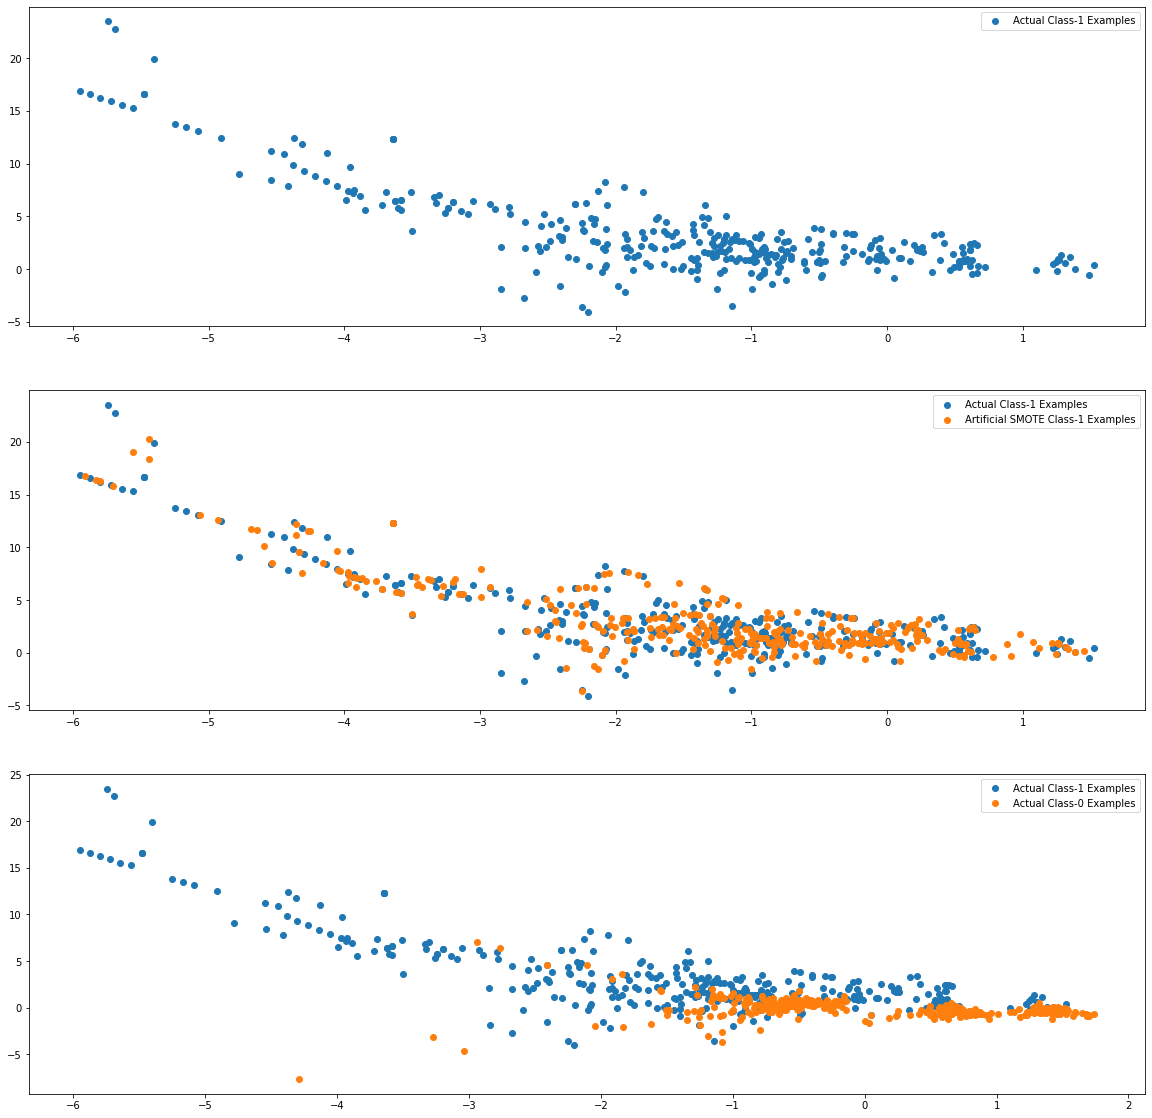

In [60]:
import warnings
warnings.filterwarnings("ignore")
from imblearn import over_sampling

sm = over_sampling.SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_smote[X_train.shape[0]:].to_numpy()

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]


plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1[:X_train_1.shape[0], 0], X_train_smote_1[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()


## Model Building - SMOTE

In [61]:
models = {
    'Random Forest-SMOTE': (RandomForestClassifier(), {
        'n_estimators': [10, 50],
        'max_depth': [ 10,20,30]
    }),
    'Logistic Regression-SMOTE': (LogisticRegression(solver='lbfgs', max_iter=1000), {
        'C': [0.1, 1]
    }),
    'XGBoost-SMOTE' : (XGBClassifier(max_depth=2, n_estimators=200),{
                'learning_rate': [0.2, 0.6],
                'subsample': [0.3, 0.6, 0.9]
    }),
    'DecisionTree-SMOTE' : (DecisionTreeClassifier(),{
                'max_depth': range(5, 15, 5),
                'min_samples_leaf': range(50, 150, 50),
                'min_samples_split': range(50, 150, 50),

    }),
    'KNN-SMOTE' : (KNeighborsClassifier(),{
        'n_neighbors': [3, 5, 7],  # You can adjust the number of neighbors to search
        'weights': ['uniform', 'distance'],
    }),

}

Processing for the Model : RandomForestClassifier() 
Splitting train and test for the Model : RandomForestClassifier() 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : RandomForestClassifier()  with hyperparamer {'n_estimators': [10, 50], 'max_depth': [10, 20, 30]}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......................max_depth=10, n_estimators=10; total time=  11.5s
[CV] END ......................max_depth=10, n_estimators=10; total time=  11.4s
[CV] END ......................max_depth=10, n_estimators=10; total time=  11.5s
[CV] END ......................max_depth=10, n_estimators=10; total time=  11.5s
[CV] END ......................max_depth=10, n_estimators=10; total time=  11.6s
[CV] END ......................max_depth=10, n_estimators=50; total time=  58.0s
[CV] END ......................max_depth=10, n_estimators=50; total time=  58.2s
[CV] END ......................max_depth=10, n_estimators=50; total time= 

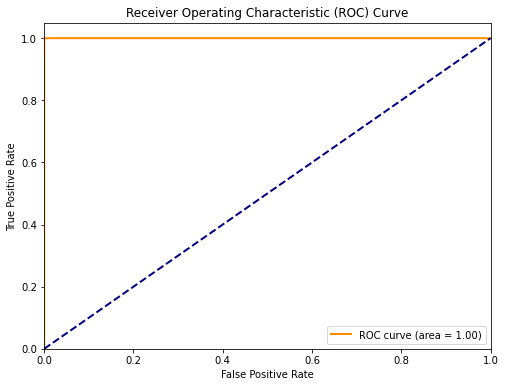

The CV results for the model RandomForestClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,11.417404,0.064761,0.070704,0.006853,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.999638,0.999644,0.999637,...,0.999676,0.000051,6,0.999725,0.999792,0.999768,0.999747,0.999748,0.999756,2.279049e-05
1,57.862764,1.200154,0.232251,0.006885,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.999828,0.999772,0.999747,...,0.999802,0.000041,5,0.999866,0.999857,0.999855,0.999844,0.999874,0.999859,1.024930e-05
2,15.019405,0.359077,0.074227,0.003399,20,10,"{'max_depth': 20, 'n_estimators': 10}",0.999949,0.999961,0.999984,...,0.999974,0.000017,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.518278e-08
3,76.523018,1.145614,0.299785,0.015032,20,50,"{'max_depth': 20, 'n_estimators': 50}",0.999999,0.999991,0.999996,...,0.999996,0.000003,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.060462e-10
4,15.250101,0.242058,0.075912,0.005788,30,10,"{'max_depth': 30, 'n_estimators': 10}",0.999964,0.999950,0.999961,...,0.999965,0.000010,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.136547e-10
5,75.724581,0.748177,0.277042,0.008815,30,50,"{'max_depth': 30, 'n_estimators': 50}",0.999996,0.999997,0.999997,...,0.999998,0.000001,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.930137e-17


The Metrics for the best score 0.9999977548916785  and Best Estimator RandomForestClassifier(max_depth=30, n_estimators=50) 
Processing for the Model : LogisticRegression(max_iter=1000) 
Splitting train and test for the Model : LogisticRegression(max_iter=1000) 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : LogisticRegression(max_iter=1000)  with hyperparamer {'C': [0.1, 1]}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..............................................C=0.1; total time=   1.6s
[CV] END ..............................................C=0.1; total time=   1.6s
[CV] END ..............................................C=0.1; total time=   1.4s
[CV] END ..............................................C=0.1; total time=   1.5s
[CV] END ..............................................C=0.1; total time=   1.4s
[CV] END ................................................C=1; total time=   1.5s
[CV] END ................................

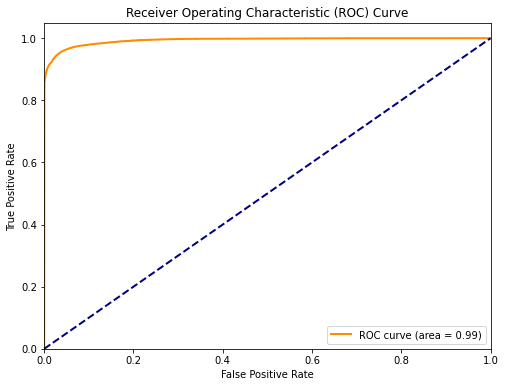

The CV results for the model LogisticRegression(max_iter=1000) 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.483196,0.073104,0.028351,0.005159,0.1,{'C': 0.1},0.992861,0.992095,0.992340,0.992441,...,0.992381,0.000269,2,0.992278,0.992508,0.992394,0.992371,0.992440,0.992398,0.000076
1,1.521855,0.066578,0.030068,0.010842,1,{'C': 1},0.992876,0.992105,0.992358,0.992459,...,0.992397,0.000270,1,0.992295,0.992523,0.992409,0.992387,0.992456,0.992414,0.000075


The Metrics for the best score 0.9923965868645294  and Best Estimator LogisticRegression(C=1, max_iter=1000) 
Processing for the Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 
Splitting train and test for the Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
      

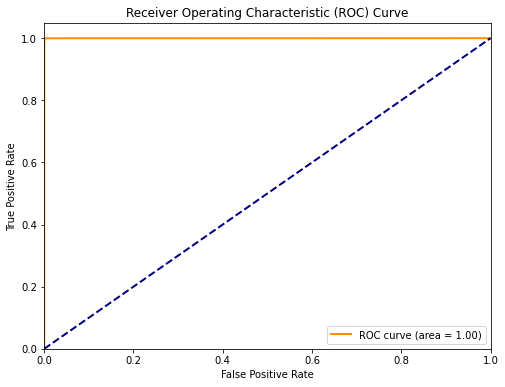

The CV results for the model XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,6.338623,0.414923,0.051733,0.008401,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.999801,0.999666,0.999695,...,0.999752,0.000059,4,0.999790,0.999771,0.999796,0.999792,0.999772,0.999784,0.000010
1,6.146514,0.943703,0.059056,0.011074,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.999790,0.999695,0.999651,...,0.999741,0.000059,5,0.999769,0.999785,0.999772,0.999777,0.999762,0.999773,0.000008
2,6.538738,0.460182,0.059413,0.010011,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.999782,0.999666,0.999649,...,0.999730,0.000060,6,0.999776,0.999764,0.999771,0.999767,0.999758,0.999767,0.000006
3,6.387854,0.347205,0.060800,0.017858,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.999955,0.999967,0.999913,...,0.999951,0.000021,3,0.999982,0.999978,0.999981,0.999979,0.999972,0.999978,0.000004
4,6.520991,0.283822,0.048637,0.003074,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.999974,0.999948,0.999928,...,0.999956,0.000018,2,0.999983,0.999982,0.999983,0.999987,0.999985,0.999984,0.000002
5,5.727460,0.302743,0.051060,0.005918,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.999957,0.999952,0.999929,...,0.999957,0.000018,1,0.999981,0.999988,0.999991,0.999985,0.999979,0.999985,0.000004


The Metrics for the best score 0.9999572073118663  and Best Estimator XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 
Processing for the Model : DecisionTreeClassifier() 
Splitting train and test for the Model : DecisionTreeClassifier() 
Creating KFold object with 5 splits
Configuring hyper pa

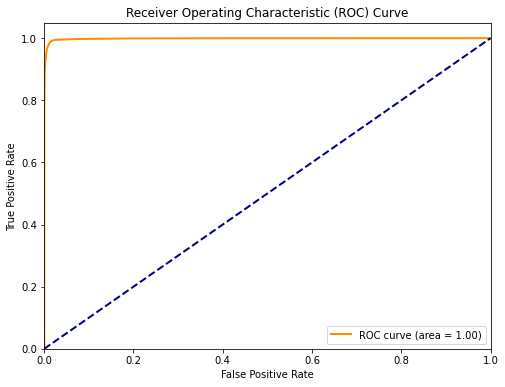

The CV results for the model DecisionTreeClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.871134,0.032878,0.022366,0.001524,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.991880,0.990910,...,0.991322,0.000332,8,0.991645,0.991494,0.991476,0.991658,0.991589,0.991572,0.000075
1,4.902847,0.048849,0.020993,0.000298,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.991880,0.990948,...,0.991329,0.000323,7,0.991645,0.991494,0.991476,0.991658,0.991589,0.991572,0.000075
2,5.046290,0.048479,0.021518,0.000702,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.991862,0.990910,...,0.991341,0.000338,5,0.991628,0.991514,0.991470,0.991736,0.991591,0.991588,0.000093
3,4.995369,0.015769,0.021059,0.000197,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.991862,0.990910,...,0.991341,0.000338,5,0.991628,0.991514,0.991470,0.991736,0.991591,0.991588,0.000093
4,9.072922,0.307745,0.024616,0.001651,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.998495,0.998445,...,0.998508,0.000118,1,0.998938,0.999035,0.999049,0.999036,0.998864,0.998984,0.000072
5,9.074595,0.252716,0.024466,0.003992,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.998497,0.998456,...,0.998499,0.000087,2,0.998938,0.999035,0.999050,0.999036,0.998871,0.998986,0.000070
6,8.997259,0.277871,0.025139,0.004035,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.998541,0.998197,...,0.998472,0.000166,4,0.998810,0.998840,0.998881,0.998881,0.998778,0.998838,0.000040
7,9.016998,0.262356,0.026292,0.004999,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.998513,0.998188,...,0.998472,0.000163,3,0.998810,0.998803,0.998878,0.998881,0.998778,0.998830,0.000042


The Metrics for the best score 0.9985079525543507  and Best Estimator DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50) 
Processing for the Model : KNeighborsClassifier() 
Splitting train and test for the Model : KNeighborsClassifier() 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : KNeighborsClassifier()  with hyperparamer {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................n_neighbors=3, weights=uniform; total time=  15.6s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  15.4s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  15.5s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  15.5s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  15.5s
[CV] END ....................n_neighbors=3, weights=distance; total time=  15.6s
[

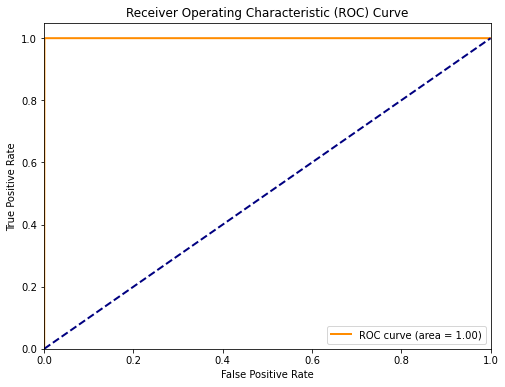

The CV results for the model KNeighborsClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.075882,0.018240,15.429031,0.073836,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.999637,0.999453,0.999529,...,0.999576,0.000082,5,1.0,1.0,1.0,1.0,1.0,1.0,1.755275e-09
1,0.068292,0.015288,15.538463,0.216527,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.999637,0.999453,0.999529,...,0.999576,0.000082,3,1.0,1.0,1.0,1.0,1.0,1.0,0.000000e+00
2,0.057624,0.003487,15.937142,0.505719,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.999637,0.999453,0.999529,...,0.999576,0.000082,6,1.0,1.0,1.0,1.0,1.0,1.0,8.182844e-09
3,0.057501,0.003118,15.551128,0.096025,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.999637,0.999453,0.999529,...,0.999576,0.000082,4,1.0,1.0,1.0,1.0,1.0,1.0,0.000000e+00
4,0.061592,0.007862,15.885649,0.376612,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.999637,0.999468,0.999545,...,0.999592,0.000080,2,1.0,1.0,1.0,1.0,1.0,1.0,7.404216e-09
5,0.072242,0.022839,15.787921,0.216263,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.999637,0.999468,0.999545,...,0.999592,0.000080,1,1.0,1.0,1.0,1.0,1.0,1.0,0.000000e+00


The Metrics for the best score 0.9995917026999317  and Best Estimator KNeighborsClassifier(n_neighbors=7, weights='distance') 
Final Metrics and the Model information
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX




,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC,Threshold,ROC AUC - Test Data,sensitivity,specificity
0,Random Forest-ROS,0.999962,0.999925,1.000000,0.999962,"(DecisionTreeClassifier(max_depth=30, max_feat...","[[39833, 3], [0, 39772]]",1.000000,0.020000,0.930920,1.000000,0.999925
1,Random Forest-SMOTE,0.999862,0.999723,1.000000,0.999862,"(DecisionTreeClassifier(max_depth=30, max_feat...","[[39825, 11], [0, 39772]]",1.000000,NaN,NaN,1.000000,0.999724
2,XGBoost-ROS,0.999837,0.999673,1.000000,0.999837,"XGBClassifier(base_score=None, booster=None, c...","[[39823, 13], [0, 39772]]",0.999995,0.000614,0.973316,1.000000,0.999674
3,XGBoost-SMOTE,0.998920,0.997992,0.999849,0.998920,"XGBClassifier(base_score=None, booster=None, c...","[[39756, 80], [6, 39766]]",0.999982,NaN,NaN,0.999849,0.997992
4,KNN-ROS,0.999686,0.999372,1.000000,0.999686,KNeighborsClassifier(n_neighbors=3),"[[39811, 25], [0, 39772]]",0.999912,0.333333,0.911993,1.000000,0.999372
5,DecisionTree-ROS,0.998179,0.996367,1.000000,0.998180,"DecisionTreeClassifier(max_depth=10, min_sampl...","[[39691, 145], [0, 39772]]",0.999798,0.842391,0.897927,1.000000,0.996360
6,KNN-SMOTE,0.998983,0.997968,1.000000,0.998983,"KNeighborsClassifier(n_neighbors=7, weights='d...","[[39755, 81], [0, 39772]]",0.999762,NaN,NaN,1.000000,0.997967
7,DecisionTree-SMOTE,0.987099,0.983672,0.990622,0.987134,"DecisionTreeClassifier(max_depth=10, min_sampl...","[[39182, 654], [373, 39399]]",0.998438,NaN,NaN,0.990622,0.983583
8,XGBoost,0.999649,0.923077,0.827586,0.872727,"XGBClassifier(base_score=None, booster=None, c...","[[39811, 4], [10, 48]]",0.993420,0.001270,0.970916,0.827586,0.999900
9,Logistic Regression,0.999273,0.822222,0.637931,0.718447,"LogisticRegression(C=0.1, max_iter=1000)","[[39807, 8], [21, 37]]",0.993083,0.003445,0.967315,0.637931,0.999799


In [62]:
metrics_df = create_classification_report(models,metrics_df,X_train_smote, y_train_smote)

AUC score for the Model Random Forest-SMOTE : 0.9501814846090595
Threshold for the model Random Forest-SMOTE  = 0.04 
RoC curve for model Random Forest-SMOTE 


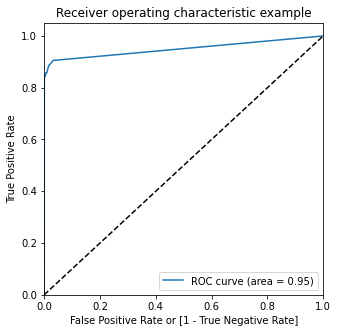

AUC score for the Model Logistic Regression-SMOTE : 0.9685826059954087
Threshold for the model Logistic Regression-SMOTE  = 0.38329267724633487 
RoC curve for model Logistic Regression-SMOTE 


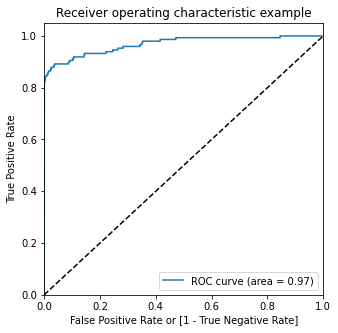

AUC score for the Model XGBoost-SMOTE : 0.9687663482698361
Threshold for the model XGBoost-SMOTE  = 0.00479114567860961 
RoC curve for model XGBoost-SMOTE 


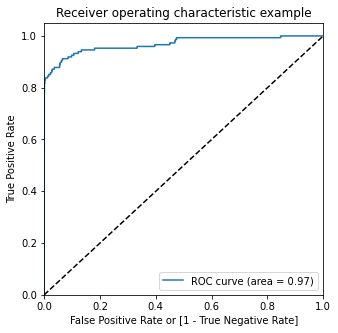

AUC score for the Model DecisionTree-SMOTE : 0.9005010828872133
Threshold for the model DecisionTree-SMOTE  = 0.16 
RoC curve for model DecisionTree-SMOTE 


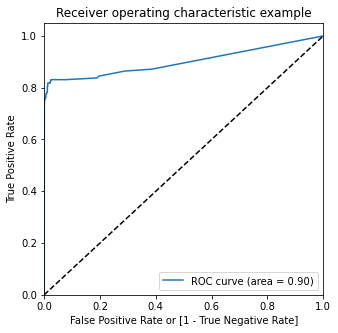

AUC score for the Model KNN-SMOTE : 0.9215714776855524
Threshold for the model KNN-SMOTE  = 0.6378333786018502 
RoC curve for model KNN-SMOTE 


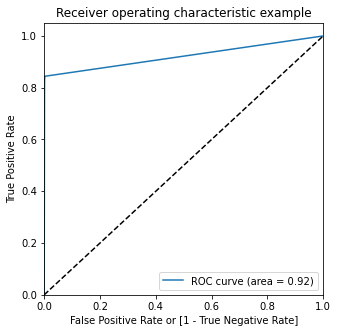

In [63]:
metrics_df = create_model_threshold(models,metrics_df)

In [64]:
display(metrics_df.sort_values(by=['ROC AUC'],ascending=False).reset_index(drop=True))

,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC,Threshold,ROC AUC - Test Data,sensitivity,specificity
0,Random Forest-ROS,0.999962,0.999925,1.000000,0.999962,"(DecisionTreeClassifier(max_depth=30, max_feat...","[[39833, 3], [0, 39772]]",1.000000,0.020000,0.930920,1.000000,0.999925
1,Random Forest-SMOTE,0.999862,0.999723,1.000000,0.999862,"(DecisionTreeClassifier(max_depth=30, max_feat...","[[39825, 11], [0, 39772]]",1.000000,0.040000,0.950181,1.000000,0.999724
2,XGBoost-ROS,0.999837,0.999673,1.000000,0.999837,"XGBClassifier(base_score=None, booster=None, c...","[[39823, 13], [0, 39772]]",0.999995,0.000614,0.973316,1.000000,0.999674
3,XGBoost-SMOTE,0.998920,0.997992,0.999849,0.998920,"XGBClassifier(base_score=None, booster=None, c...","[[39756, 80], [6, 39766]]",0.999982,0.004791,0.968766,0.999849,0.997992
4,KNN-ROS,0.999686,0.999372,1.000000,0.999686,KNeighborsClassifier(n_neighbors=3),"[[39811, 25], [0, 39772]]",0.999912,0.333333,0.911993,1.000000,0.999372
5,DecisionTree-ROS,0.998179,0.996367,1.000000,0.998180,"DecisionTreeClassifier(max_depth=10, min_sampl...","[[39691, 145], [0, 39772]]",0.999798,0.842391,0.897927,1.000000,0.996360
6,KNN-SMOTE,0.998983,0.997968,1.000000,0.998983,"KNeighborsClassifier(n_neighbors=7, weights='d...","[[39755, 81], [0, 39772]]",0.999762,0.637833,0.921571,1.000000,0.997967
7,DecisionTree-SMOTE,0.987099,0.983672,0.990622,0.987134,"DecisionTreeClassifier(max_depth=10, min_sampl...","[[39182, 654], [373, 39399]]",0.998438,0.160000,0.900501,0.990622,0.983583
8,XGBoost,0.999649,0.923077,0.827586,0.872727,"XGBClassifier(base_score=None, booster=None, c...","[[39811, 4], [10, 48]]",0.993420,0.001270,0.970916,0.827586,0.999900
9,Logistic Regression,0.999273,0.822222,0.637931,0.718447,"LogisticRegression(C=0.1, max_iter=1000)","[[39807, 8], [21, 37]]",0.993083,0.003445,0.967315,0.637931,0.999799


##### Build models on other algorithms to see the better performing on SMOTE

### Print the class distribution after applying ADASYN

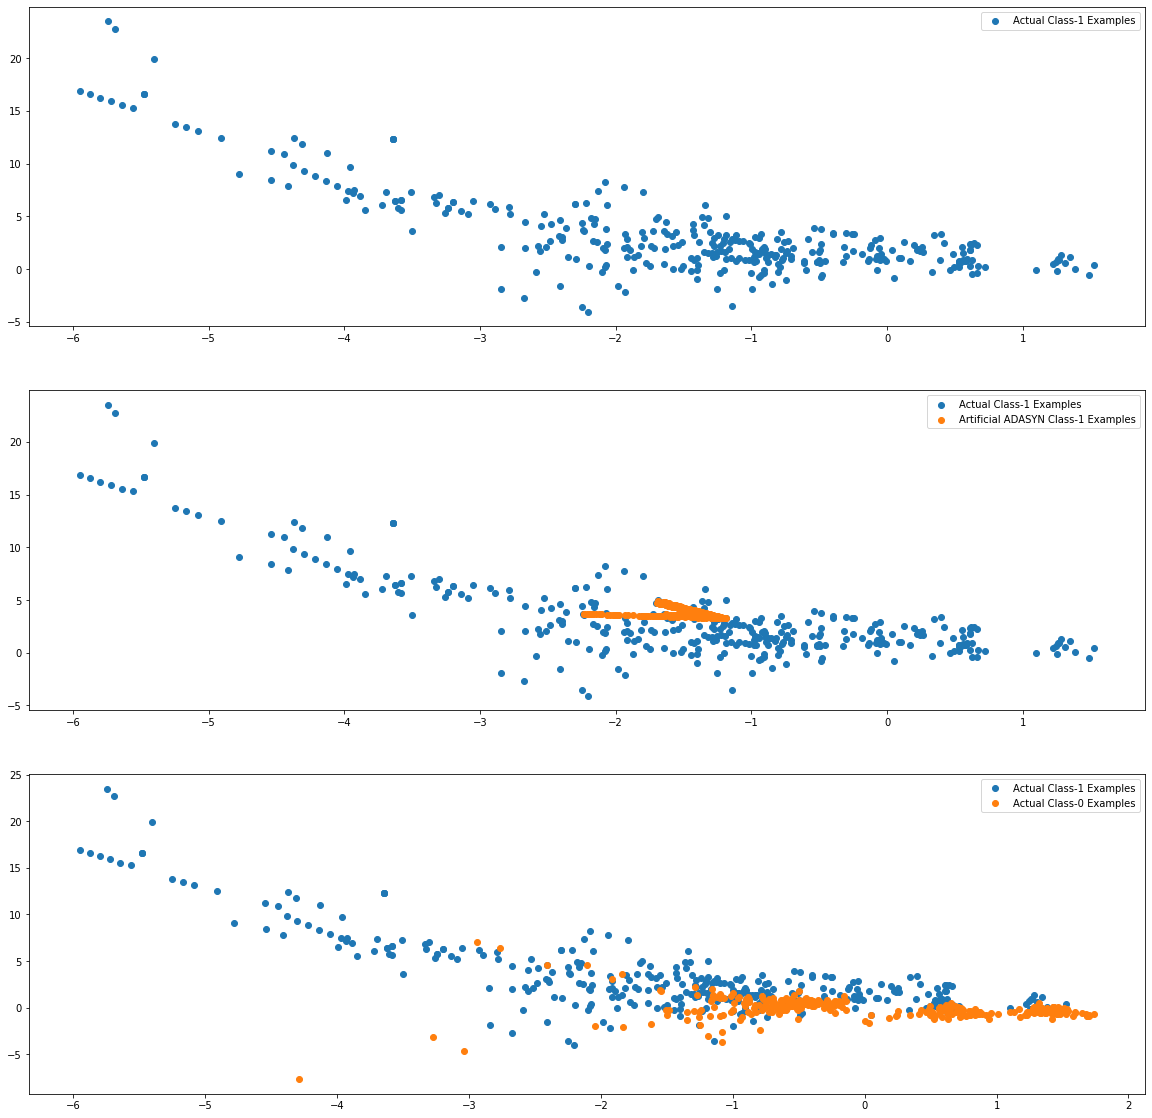

In [65]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:].to_numpy()

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]



import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()
plt.show()

##### Build models on other algorithms to see the better performing on ADASYN

In [66]:
models = {
    'Random Forest-ADASYN': (RandomForestClassifier(), {
        'n_estimators': [10, 50],
        'max_depth': [ 10,20,30]
    }),
    'Logistic Regression-ADASYN': (LogisticRegression(solver='lbfgs', max_iter=1000), {
        'C': [0.1, 1]
    }),
    'XGBoost-ADASYN' : (XGBClassifier(max_depth=2, n_estimators=200),{
                'learning_rate': [0.2, 0.6],
                'subsample': [0.3, 0.6, 0.9]
    }),
    'DecisionTree-ADASYN' : (DecisionTreeClassifier(),{
                'max_depth': range(5, 15, 5),
                'min_samples_leaf': range(50, 150, 50),
                'min_samples_split': range(50, 150, 50),

    }),
    'KNN-ADASYN' : (KNeighborsClassifier(),{
        'n_neighbors': [3, 5, 7],  # You can adjust the number of neighbors to search
        'weights': ['uniform', 'distance'],
    }),

}


Processing for the Model : RandomForestClassifier() 
Splitting train and test for the Model : RandomForestClassifier() 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : RandomForestClassifier()  with hyperparamer {'n_estimators': [10, 50], 'max_depth': [10, 20, 30]}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......................max_depth=10, n_estimators=10; total time=  12.2s
[CV] END ......................max_depth=10, n_estimators=10; total time=  12.1s
[CV] END ......................max_depth=10, n_estimators=10; total time=  11.9s
[CV] END ......................max_depth=10, n_estimators=10; total time=  12.1s
[CV] END ......................max_depth=10, n_estimators=10; total time=  12.3s
[CV] END ......................max_depth=10, n_estimators=50; total time= 1.0min
[CV] END ......................max_depth=10, n_estimators=50; total time=  58.9s
[CV] END ......................max_depth=10, n_estimators=50; total time= 

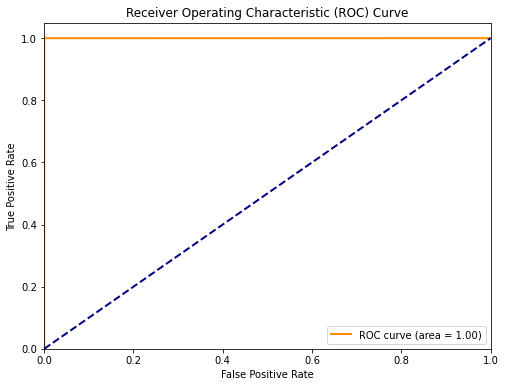

The CV results for the model RandomForestClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,12.050614,0.113432,0.074878,0.004821,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.999531,0.999417,0.999494,...,0.999450,0.000055,6,0.999515,0.999574,0.999644,0.999533,0.999592,0.999572,4.530289e-05
1,59.256639,0.461563,0.247994,0.005693,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.999801,0.999679,0.999700,...,0.999700,0.000066,5,0.999777,0.999758,0.999828,0.999781,0.999734,0.999776,3.104543e-05
2,16.723588,0.182503,0.076863,0.001641,20,10,"{'max_depth': 20, 'n_estimators': 10}",0.999945,0.999926,0.999916,...,0.999933,0.000023,4,0.999999,1.000000,1.000000,0.999989,0.999985,0.999995,6.267189e-06
3,82.136979,1.221423,0.298173,0.012475,20,50,"{'max_depth': 20, 'n_estimators': 50}",0.999973,0.999973,0.999998,...,0.999988,0.000013,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.903184e-10
4,18.805243,0.431600,0.086812,0.009610,30,10,"{'max_depth': 30, 'n_estimators': 10}",0.999974,0.999922,0.999999,...,0.999968,0.000030,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.611773e-08
5,91.767394,0.956508,0.323624,0.009121,30,50,"{'max_depth': 30, 'n_estimators': 50}",0.999977,0.999970,0.999999,...,0.999989,0.000013,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.021667e-17


The Metrics for the best score 0.9999889345576376  and Best Estimator RandomForestClassifier(max_depth=30, n_estimators=50) 
Processing for the Model : LogisticRegression(max_iter=1000) 
Splitting train and test for the Model : LogisticRegression(max_iter=1000) 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : LogisticRegression(max_iter=1000)  with hyperparamer {'C': [0.1, 1]}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..............................................C=0.1; total time=   1.5s
[CV] END ..............................................C=0.1; total time=   1.5s
[CV] END ..............................................C=0.1; total time=   1.2s
[CV] END ..............................................C=0.1; total time=   1.5s
[CV] END ..............................................C=0.1; total time=   1.5s
[CV] END ................................................C=1; total time=   1.5s
[CV] END ................................

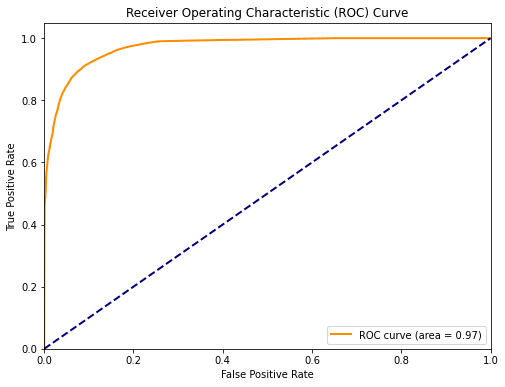

The CV results for the model LogisticRegression(max_iter=1000) 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.412729,0.106700,0.029872,0.006423,0.1,{'C': 0.1},0.972776,0.973103,0.972294,0.970887,...,0.972398,0.000802,2,0.972277,0.972232,0.972483,0.972818,0.972306,0.972424,0.000215
1,1.338679,0.098008,0.031624,0.007140,1,{'C': 1},0.972790,0.973119,0.972308,0.970916,...,0.972417,0.000798,1,0.972298,0.972251,0.972501,0.972839,0.972325,0.972443,0.000216


The Metrics for the best score 0.9724169658601838  and Best Estimator LogisticRegression(C=1, max_iter=1000) 
Processing for the Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 
Splitting train and test for the Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
      

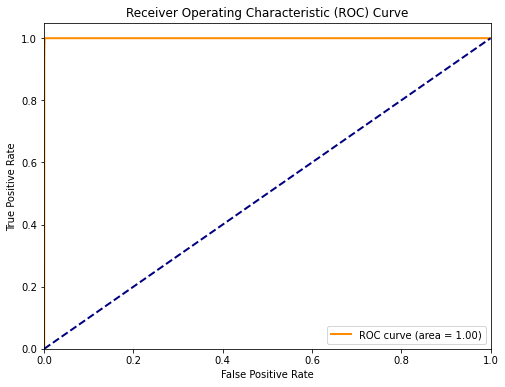

The CV results for the model XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,6.761641,0.380808,0.062670,0.016026,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.999141,0.999172,0.999162,...,0.999141,0.000024,4,0.999210,0.999215,0.999231,0.999133,0.999229,0.999204,0.000036
1,6.498796,0.575563,0.056564,0.007245,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.999153,0.999192,0.999131,...,0.999131,0.000062,5,0.999180,0.999201,0.999190,0.999203,0.999198,0.999195,0.000008
2,5.923717,0.654457,0.061881,0.014245,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.999172,0.999147,0.999115,...,0.999113,0.000054,6,0.999196,0.999173,0.999199,0.999166,0.999189,0.999185,0.000013
3,6.574438,0.937922,0.059046,0.006291,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.999889,0.999861,0.999880,...,0.999870,0.000020,3,0.999935,0.999910,0.999942,0.999940,0.999919,0.999929,0.000013
4,6.430527,0.213362,0.053567,0.007751,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.999883,0.999936,0.999903,...,0.999885,0.000032,2,0.999935,0.999943,0.999934,0.999948,0.999928,0.999938,0.000007
5,6.228349,0.269985,0.053673,0.002811,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.999913,0.999895,0.999938,...,0.999899,0.000027,1,0.999955,0.999942,0.999942,0.999938,0.999931,0.999942,0.000008


The Metrics for the best score 0.9998989402894345  and Best Estimator XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 
Processing for the Model : DecisionTreeClassifier() 
Splitting train and test for the Model : DecisionTreeClassifier() 
Creating KFold object with 5 splits
Configuring hyper pa

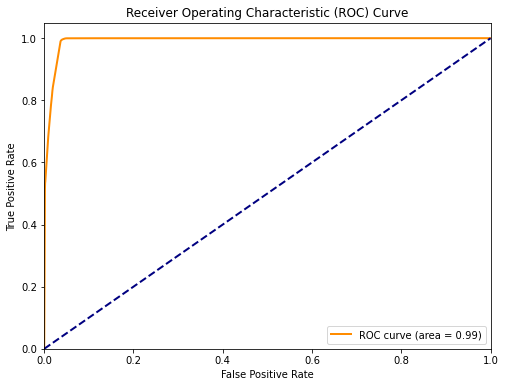

The CV results for the model DecisionTreeClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.930575,0.040778,0.022433,0.000901,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.970797,0.972174,...,0.970588,0.000894,5,0.971183,0.971652,0.970514,0.971861,0.969916,0.971025,0.000722
1,4.877904,0.037085,0.022040,0.000451,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.970797,0.972174,...,0.970588,0.000894,5,0.971183,0.971652,0.970514,0.971861,0.969916,0.971025,0.000722
2,4.909725,0.048057,0.022647,0.001310,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.970765,0.972161,...,0.970559,0.000907,8,0.971160,0.971623,0.970494,0.971840,0.969891,0.971002,0.000722
3,4.882573,0.018002,0.021958,0.000444,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.970765,0.972161,...,0.970559,0.000907,7,0.971160,0.971623,0.970494,0.971840,0.969891,0.971002,0.000722
4,8.375600,0.383121,0.022594,0.000694,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.993351,0.993215,...,0.992951,0.000882,2,0.993585,0.993710,0.994370,0.992861,0.993463,0.993598,0.000484
5,8.286089,0.360320,0.022464,0.000229,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.993390,0.993286,...,0.992961,0.000887,1,0.993590,0.993704,0.994370,0.992861,0.993463,0.993598,0.000483
6,8.248916,0.347219,0.025023,0.005678,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.993274,0.993397,...,0.992847,0.001003,4,0.993527,0.993578,0.994343,0.992530,0.993197,0.993435,0.000588
7,8.307943,0.367500,0.022218,0.000338,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.993280,0.993394,...,0.992862,0.000991,3,0.993527,0.993601,0.994343,0.992535,0.993197,0.993441,0.000588


The Metrics for the best score 0.9929608778870989  and Best Estimator DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=100) 
Processing for the Model : KNeighborsClassifier() 
Splitting train and test for the Model : KNeighborsClassifier() 
Creating KFold object with 5 splits
Configuring hyper parameter  for the Model : KNeighborsClassifier()  with hyperparamer {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................n_neighbors=3, weights=uniform; total time=  15.8s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  16.6s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  15.7s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  15.7s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  15.6s
[CV] END ....................n_neighbors=3, weights=distance; total time=  15.5s


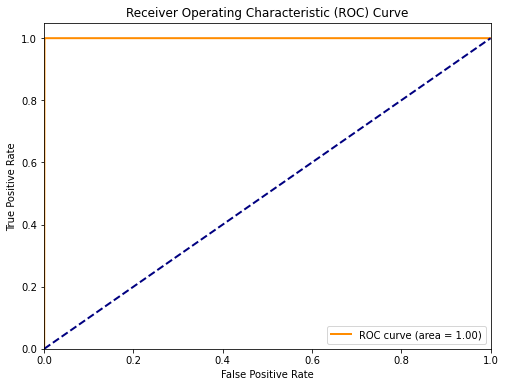

The CV results for the model KNeighborsClassifier() 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.074383,0.017951,15.811525,0.364584,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.999528,0.999575,0.999639,...,0.999538,0.000071,5,1.0,1.0,1.0,1.0,1.0,1.0,0.000000e+00
1,0.064848,0.009317,15.953245,0.452407,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.999528,0.999575,0.999639,...,0.999538,0.000071,5,1.0,1.0,1.0,1.0,1.0,1.0,0.000000e+00
2,0.057668,0.002071,15.519212,0.068467,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.999528,0.999575,0.999639,...,0.999542,0.000066,4,1.0,1.0,1.0,1.0,1.0,1.0,1.712864e-09
3,0.065854,0.009293,15.633971,0.161788,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.999528,0.999575,0.999639,...,0.999542,0.000066,3,1.0,1.0,1.0,1.0,1.0,1.0,0.000000e+00
4,0.065032,0.006019,15.960938,0.450625,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.999528,0.999590,0.999639,...,0.999545,0.000068,2,1.0,1.0,1.0,1.0,1.0,1.0,6.740330e-09
5,0.070485,0.012501,15.530848,0.074469,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.999528,0.999590,0.999639,...,0.999545,0.000068,1,1.0,1.0,1.0,1.0,1.0,1.0,0.000000e+00


The Metrics for the best score 0.9995446603004297  and Best Estimator KNeighborsClassifier(n_neighbors=7, weights='distance') 
Final Metrics and the Model information
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX




,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC,Threshold,ROC AUC - Test Data,sensitivity,specificity
0,Random Forest-ROS,0.999962,0.999925,1.000000,0.999962,"(DecisionTreeClassifier(max_depth=30, max_feat...","[[39833, 3], [0, 39772]]",1.000000,0.020000,0.930920,1.000000,0.999925
1,Random Forest-ADASYN,0.999761,0.999573,0.999950,0.999761,"(DecisionTreeClassifier(max_depth=30, max_feat...","[[39822, 17], [2, 39769]]",1.000000,NaN,NaN,0.999950,0.999573
2,Random Forest-SMOTE,0.999862,0.999723,1.000000,0.999862,"(DecisionTreeClassifier(max_depth=30, max_feat...","[[39825, 11], [0, 39772]]",1.000000,0.040000,0.950181,1.000000,0.999724
3,XGBoost-ROS,0.999837,0.999673,1.000000,0.999837,"XGBClassifier(base_score=None, booster=None, c...","[[39823, 13], [0, 39772]]",0.999995,0.000614,0.973316,1.000000,0.999674
4,XGBoost-SMOTE,0.998920,0.997992,0.999849,0.998920,"XGBClassifier(base_score=None, booster=None, c...","[[39756, 80], [6, 39766]]",0.999982,0.004791,0.968766,0.999849,0.997992
5,KNN-ROS,0.999686,0.999372,1.000000,0.999686,KNeighborsClassifier(n_neighbors=3),"[[39811, 25], [0, 39772]]",0.999912,0.333333,0.911993,1.000000,0.999372
6,XGBoost-ADASYN,0.998191,0.996492,0.999899,0.998193,"XGBClassifier(base_score=None, booster=None, c...","[[39699, 140], [4, 39767]]",0.999892,NaN,NaN,0.999899,0.996486
7,DecisionTree-ROS,0.998179,0.996367,1.000000,0.998180,"DecisionTreeClassifier(max_depth=10, min_sampl...","[[39691, 145], [0, 39772]]",0.999798,0.842391,0.897927,1.000000,0.996360
8,KNN-SMOTE,0.998983,0.997968,1.000000,0.998983,"KNeighborsClassifier(n_neighbors=7, weights='d...","[[39755, 81], [0, 39772]]",0.999762,0.637833,0.921571,1.000000,0.997967
9,KNN-ADASYN,0.998832,0.997667,1.000000,0.998832,"KNeighborsClassifier(n_neighbors=7, weights='d...","[[39746, 93], [0, 39771]]",0.999699,NaN,NaN,1.000000,0.997666


In [67]:
metrics_df = create_classification_report(models,metrics_df,X_train_adasyn, y_train_adasyn)

AUC score for the Model Random Forest-ADASYN : 0.9492901820866532
Threshold for the model Random Forest-ADASYN  = 0.05967313547310954 
RoC curve for model Random Forest-ADASYN 


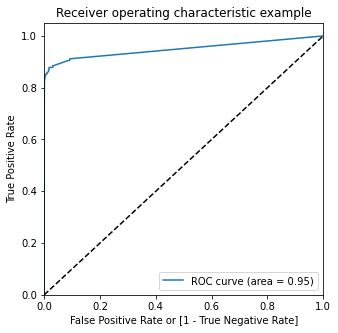

AUC score for the Model Logistic Regression-ADASYN : 0.9687639321718107
Threshold for the model Logistic Regression-ADASYN  = 0.8803662000861263 
RoC curve for model Logistic Regression-ADASYN 


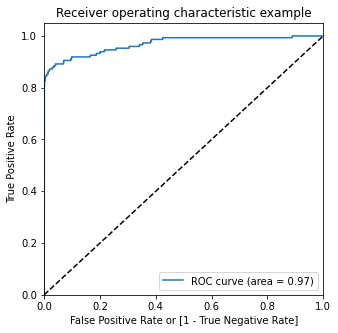

AUC score for the Model XGBoost-ADASYN : 0.9703242165901174
Threshold for the model XGBoost-ADASYN  = 0.038582708686590195 
RoC curve for model XGBoost-ADASYN 


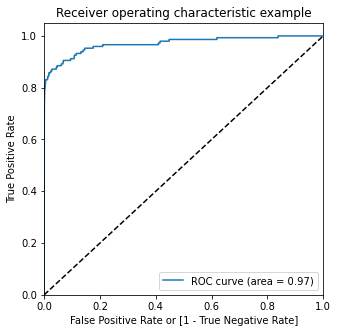

AUC score for the Model DecisionTree-ADASYN : 0.9028353108369522
Threshold for the model DecisionTree-ADASYN  = 0.9133403361344538 
RoC curve for model DecisionTree-ADASYN 


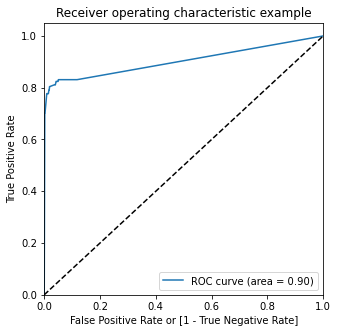

AUC score for the Model KNN-ADASYN : 0.9215624866322446
Threshold for the model KNN-ADASYN  = 0.6378388686077521 
RoC curve for model KNN-ADASYN 


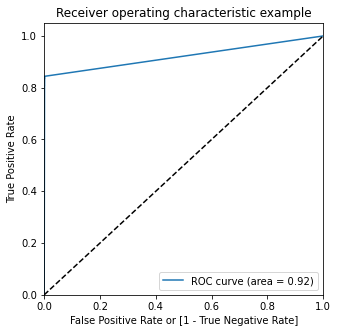

In [68]:
metrics_df = create_model_threshold(models,metrics_df)

In [69]:
display(metrics_df.sort_values(by=['ROC AUC'],ascending=False).reset_index(drop=True))

,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC,Threshold,ROC AUC - Test Data,sensitivity,specificity
0,Random Forest-ROS,0.999962,0.999925,1.000000,0.999962,"(DecisionTreeClassifier(max_depth=30, max_feat...","[[39833, 3], [0, 39772]]",1.000000,0.020000,0.930920,1.000000,0.999925
1,Random Forest-ADASYN,0.999761,0.999573,0.999950,0.999761,"(DecisionTreeClassifier(max_depth=30, max_feat...","[[39822, 17], [2, 39769]]",1.000000,0.059673,0.949290,0.999950,0.999573
2,Random Forest-SMOTE,0.999862,0.999723,1.000000,0.999862,"(DecisionTreeClassifier(max_depth=30, max_feat...","[[39825, 11], [0, 39772]]",1.000000,0.040000,0.950181,1.000000,0.999724
3,XGBoost-ROS,0.999837,0.999673,1.000000,0.999837,"XGBClassifier(base_score=None, booster=None, c...","[[39823, 13], [0, 39772]]",0.999995,0.000614,0.973316,1.000000,0.999674
4,XGBoost-SMOTE,0.998920,0.997992,0.999849,0.998920,"XGBClassifier(base_score=None, booster=None, c...","[[39756, 80], [6, 39766]]",0.999982,0.004791,0.968766,0.999849,0.997992
5,KNN-ROS,0.999686,0.999372,1.000000,0.999686,KNeighborsClassifier(n_neighbors=3),"[[39811, 25], [0, 39772]]",0.999912,0.333333,0.911993,1.000000,0.999372
6,XGBoost-ADASYN,0.998191,0.996492,0.999899,0.998193,"XGBClassifier(base_score=None, booster=None, c...","[[39699, 140], [4, 39767]]",0.999892,0.038583,0.970324,0.999899,0.996486
7,DecisionTree-ROS,0.998179,0.996367,1.000000,0.998180,"DecisionTreeClassifier(max_depth=10, min_sampl...","[[39691, 145], [0, 39772]]",0.999798,0.842391,0.897927,1.000000,0.996360
8,KNN-SMOTE,0.998983,0.997968,1.000000,0.998983,"KNeighborsClassifier(n_neighbors=7, weights='d...","[[39755, 81], [0, 39772]]",0.999762,0.637833,0.921571,1.000000,0.997967
9,KNN-ADASYN,0.998832,0.997667,1.000000,0.998832,"KNeighborsClassifier(n_neighbors=7, weights='d...","[[39746, 93], [0, 39771]]",0.999699,0.637839,0.921562,1.000000,0.997666


### Select the oversampling method which shows the best result on a model
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [117]:
display(metrics_df.sort_values(by=['ROC AUC'],ascending=False).reset_index(drop=True).head(1))

,Model,Accuracy,Precision,Recall,F1 Score,Best_Model,Confusion Matrix,ROC AUC,Threshold,ROC AUC - Test Data,sensitivity,specificity
0,Random Forest-ROS,0.999962,0.999925,1.0,0.999962,"(DecisionTreeClassifier(max_depth=30, max_feat...","[[39833, 3], [0, 39772]]",1.0,0.02,0.93092,1.0,0.999925


In [118]:
print(metrics_df[metrics_df['Model'] == 'Random Forest-ROS']['Best_Model'].values[0])

RandomForestClassifier(max_depth=30, n_estimators=50)


In [119]:
# perform the best oversampling method on X_train & y_train

clf = metrics_df[metrics_df['Model'] == 'Random Forest-ROS']['Best_Model'].values[0]  #initialise the model with optimum hyperparameters
clf.fit(X_ro_resampled, y_ro_resampled) # fit on the balanced dataset


RandomForestClassifier(max_depth=30, n_estimators=50)

In [120]:
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve

best_model_score = clf.score(X_test, y_test)
print('Model Accuracy for Test Data: {0}'.format(best_model_score))

# Make predictions on the test data
y_pred = clf.predict(X_test)
    
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
sensitivity = TP / float(TP+FN)
specificity = TN / float(TN+FP)

# Calculate ROC curve and ROC AUC score
y_prob = clf.predict_proba(X_test)[:, 1]
#fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
threshold = thresholds[np.argmax(tpr-fpr)]

metrics_info = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': confusion,
        'ROC AUC': roc_auc,
        'sensitivity':sensitivity,
        'specificity' : specificity,
        'Best_Model' : clf,
        'threshold'  : threshold
     }

Model Accuracy for Test Data: 0.9994850368081645


In [121]:
for key,value in metrics_info.items():
    print("{}\t\t: {}".format(key,value))

Accuracy		: 0.9994850368081645
Precision		: 0.956140350877193
Recall		: 0.7364864864864865
F1 Score		: 0.8320610687022901
Confusion Matrix		: [[85290     5]
 [   39   109]]
ROC AUC		: 0.9347418260631226
sensitivity		: 0.7364864864864865
specificity		: 0.9999413799167595
Best_Model		: RandomForestClassifier(max_depth=30, n_estimators=50)
threshold		: 0.02


### Print the important features of the best model to understand the dataset

Top var = 10
2nd Top var = 17
3rd Top var = 14


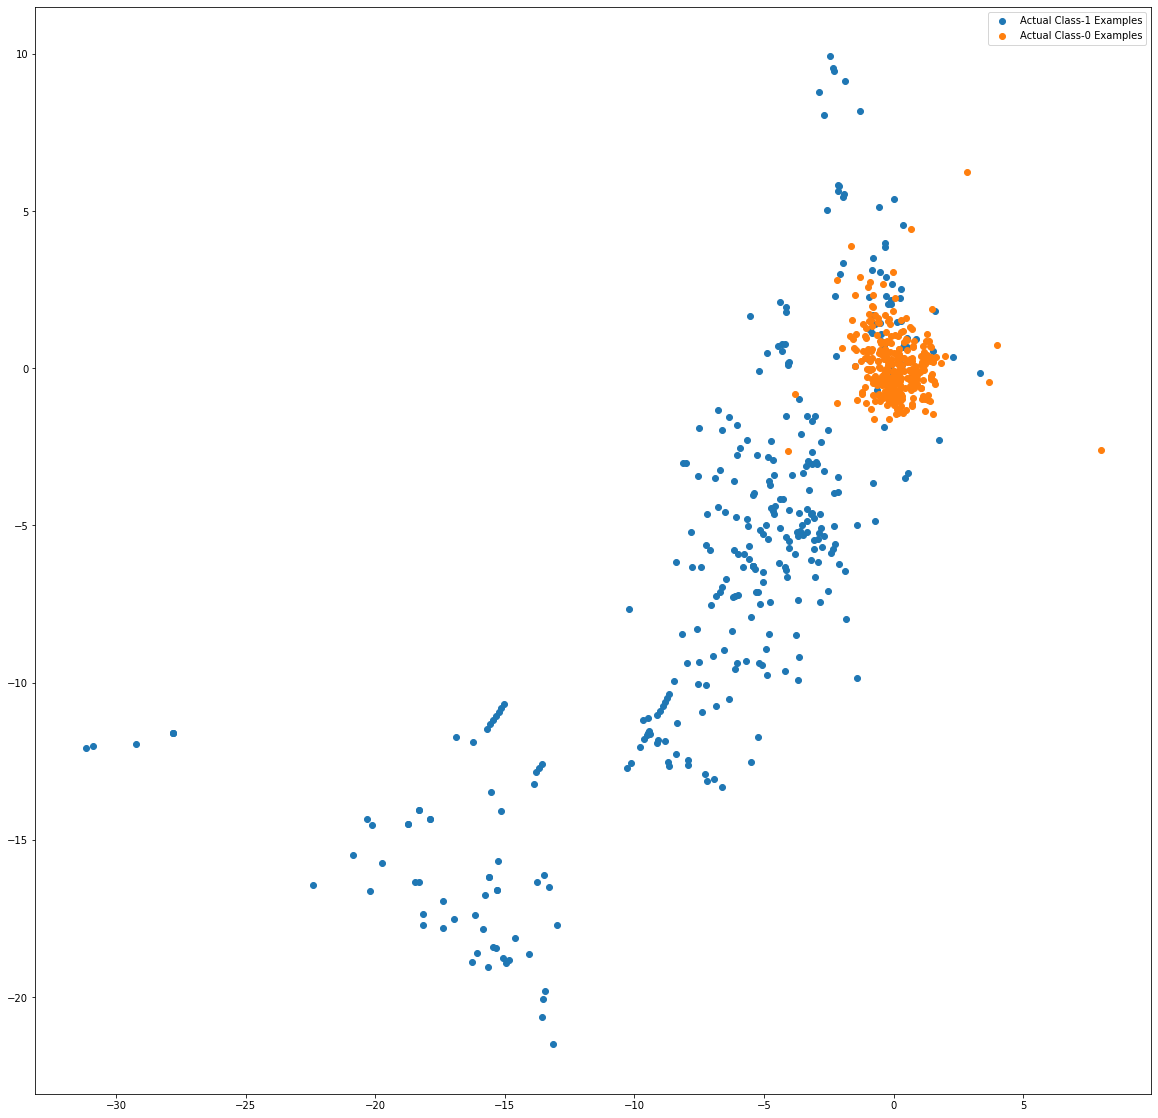

In [122]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-13 and Index-9 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()
plt.show()

In [123]:
#### Print the FPR,TPR & select the best threshold from the roc curve

In [124]:
print('Train auc =', metrics.roc_auc_score(y_test, y_prob))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
threshold = thresholds[np.argmax(tpr-fpr)]
print('Threshold from the roc curve =' ,threshold)

Train auc = 0.9347418260631226
Threshold from the roc curve = 0.02


<a id='end'></a>

# Conclusion

We have evaluated the model with Logistic regression/Random Forest / Decision Tree/XGboost and KNN . NOTE : SVN i tried it and take 1 hour 45 minutes for one fold so itis comutational expensive and time consuming. Hence i have not done wtih SVM.

 - Logistic regression works best when the data is linearly separable and needs to be
interpretable.
 - KNN is also highly interpretable, but not preferred when we have a huge amount of data
as it will consume a lot of computation.
 - The decision tree model is the first choice when we want the output to be intuitive, but
they tend to overfit if left unchecked.
 - KNN is a simple, supervised machine learning algorithm used for both classification and
regression tasks. The k value in KNN should be an odd number because you have to take the
majority vote from the nearest neighbours by breaking the ties.
 -  XGBoost is an extended version of gradient boosting, with additional features like
regularization and parallel tree learning algorithm for finding the best split.
We will start with the Logistic regression model with the different value of regularisation and
hyper param tuning, then go to the decision tree and so on etc. We will also try ensemble
models and use votingclassifier, Bagging, Boosting etc on the best performing individual
models to find the best model.

We did evaluate by the data set of Training Split which are done using stratified with RandomOverSample/SMOTE and ADSYN and compared all the Model metrics including ROC-AUC and threshold.

Overall conclusion after running models on Oversampled data:
Looking at above results it seems XGBOOST model with Random Oversampling has provided best results. So we can try to tune the hyperparameters of this model to get best results.

We have selected Random Foresst  model with RandomOversampling which provided the best matrics in our experiment .

- Accuracy		: 0.9994850368081645
- Precision		: 0.956140350877193
- Recall     	: 0.7364864864864865
- F1 Score		: 0.8320610687022901
- ROC AUC		: 0.9347418260631226
- sensitivity	: 0.7364864864864865
- specificity	: 0.9999413799167595
- Best_Model		: RandomForestClassifier(max_depth=30, n_estimators=50)
- threshold		: 0.02
